In [1]:
import torch
import os
import math
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets, models, transforms

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler 
import torch.backends.cudnn as cudnn 
import numpy as np
import torchvision
from torchvision import datasets, models, transforms 
import matplotlib.pyplot as plt
import time
import os
import copy
import glob
import itertools
from PIL import Image
from tqdm import tqdm
from pathlib import Path
from PIL import Image
from IPython.display import display, Image, clear_output 
import ipywidgets as widgets
import threading

In [3]:
torch.manual_seed(111)

In [4]:
device = ""
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [5]:
import os
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader 
from PIL import Image

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    # transforms.Resize((28, 28)),
    transforms.Resize((64, 64)), 
    #transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.485], [0.229])
])
class SingleClassImageFolder(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.img_names = [img for img in os.listdir(root_dir) if img.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif'))] 
        
    def __len__(self):
        return len(self.img_names)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.img_names[idx])
        image = Image.open(img_path)
        image = image.convert('RGB') 
        if self.transform:
            image = self.transform(image)
        return image, 0 
data_dir = '/Users/nicolasortuno1/Desktop/Columbia/Fourth Year/Spring Semester/Applied Computer Vision/asl-translator/data/train'
letters = os.listdir(data_dir)

gan_datasets = {}
gan_dataloaders = {}

for letter in letters:
    letter_path = os.path.join(data_dir, letter) 
    if os.path.isdir(letter_path):
        gan_datasets[letter] = SingleClassImageFolder(root_dir=letter_path, transform=transform)
        gan_dataloaders[letter] = DataLoader(gan_datasets[letter],batch_size=32, shuffle=True, num_workers=0)

print(gan_dataloaders['A'])

In [6]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0)) 
    mean = np.array([0.485, 0.456, 0.406]) 
    std = np.array([0.229, 0.224, 0.225]) 
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1) 
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

torch.Size([32, 1, 64, 64])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
torch.Size([3, 266, 530])


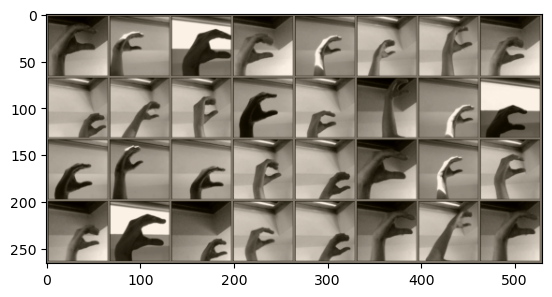

In [7]:
# Get a batch of training data
inputs, classes = next(iter(gan_dataloaders['C']))
print(inputs.shape)
print(classes)
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
print(out.shape)
imshow(out)

In [8]:
class Discriminator(nn.Module): 
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(nn.Linear(4096, 2048),
            nn.Dropout(0.3),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 1),
            nn.Sigmoid(),
        )
    
    def forward(self, x):
        x = x.view(x.size(0), 4096)
        output = self.model(x)
        return output
    
discriminator = Discriminator().to(device)

In [9]:
class Generator(nn.Module): 
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 2048),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(2048, 4096),
            nn.Tanh(),
        )
        
    def forward(self, x):
        output = self.model(x)
        output = output.view(x.size(0), 1, 64, 64) 
        return output

generator = Generator().to(device)

In [10]:
def show_asl(num_images, num_rows, num_cols, generated_samples):
    
    plt.figure(figsize=(64, 64))

    for i in range(num_images):
        plt.subplot(num_rows, num_cols, i+1)
        plt.imshow(generated_samples[i].reshape(64,64), cmap='gray')
        plt.axis('off') 

    plt.tight_layout()
    plt.show()

In [11]:
lr = 0.0001
num_epochs = 50
loss_function = nn.BCELoss()
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

Starting training for letter: R
Completed Epoch 1/50, Epoch Duration: 7.03s, Total Loss D.: 0.0490, Total Loss G.: 2.7318
Completed Epoch 2/50, Epoch Duration: 6.54s, Total Loss D.: 0.0278, Total Loss G.: 3.1995
Completed Epoch 3/50, Epoch Duration: 6.54s, Total Loss D.: 0.2920, Total Loss G.: 1.5493
Completed Epoch 4/50, Epoch Duration: 6.43s, Total Loss D.: 0.1607, Total Loss G.: 6.1055
Completed Epoch 5/50, Epoch Duration: 6.46s, Total Loss D.: 0.0293, Total Loss G.: 3.0013
Completed Epoch 6/50, Epoch Duration: 6.47s, Total Loss D.: 0.0263, Total Loss G.: 3.2735
Completed Epoch 7/50, Epoch Duration: 6.66s, Total Loss D.: 0.0070, Total Loss G.: 6.3168
Completed Epoch 8/50, Epoch Duration: 6.50s, Total Loss D.: 0.0788, Total Loss G.: 3.2725
Completed Epoch 9/50, Epoch Duration: 6.65s, Total Loss D.: 0.0834, Total Loss G.: 4.3042
Completed Epoch 10/50, Epoch Duration: 6.57s, Total Loss D.: 0.2522, Total Loss G.: 3.4550
Completed Epoch 11/50, Epoch Duration: 6.53s, Total Loss D.: 0.2351

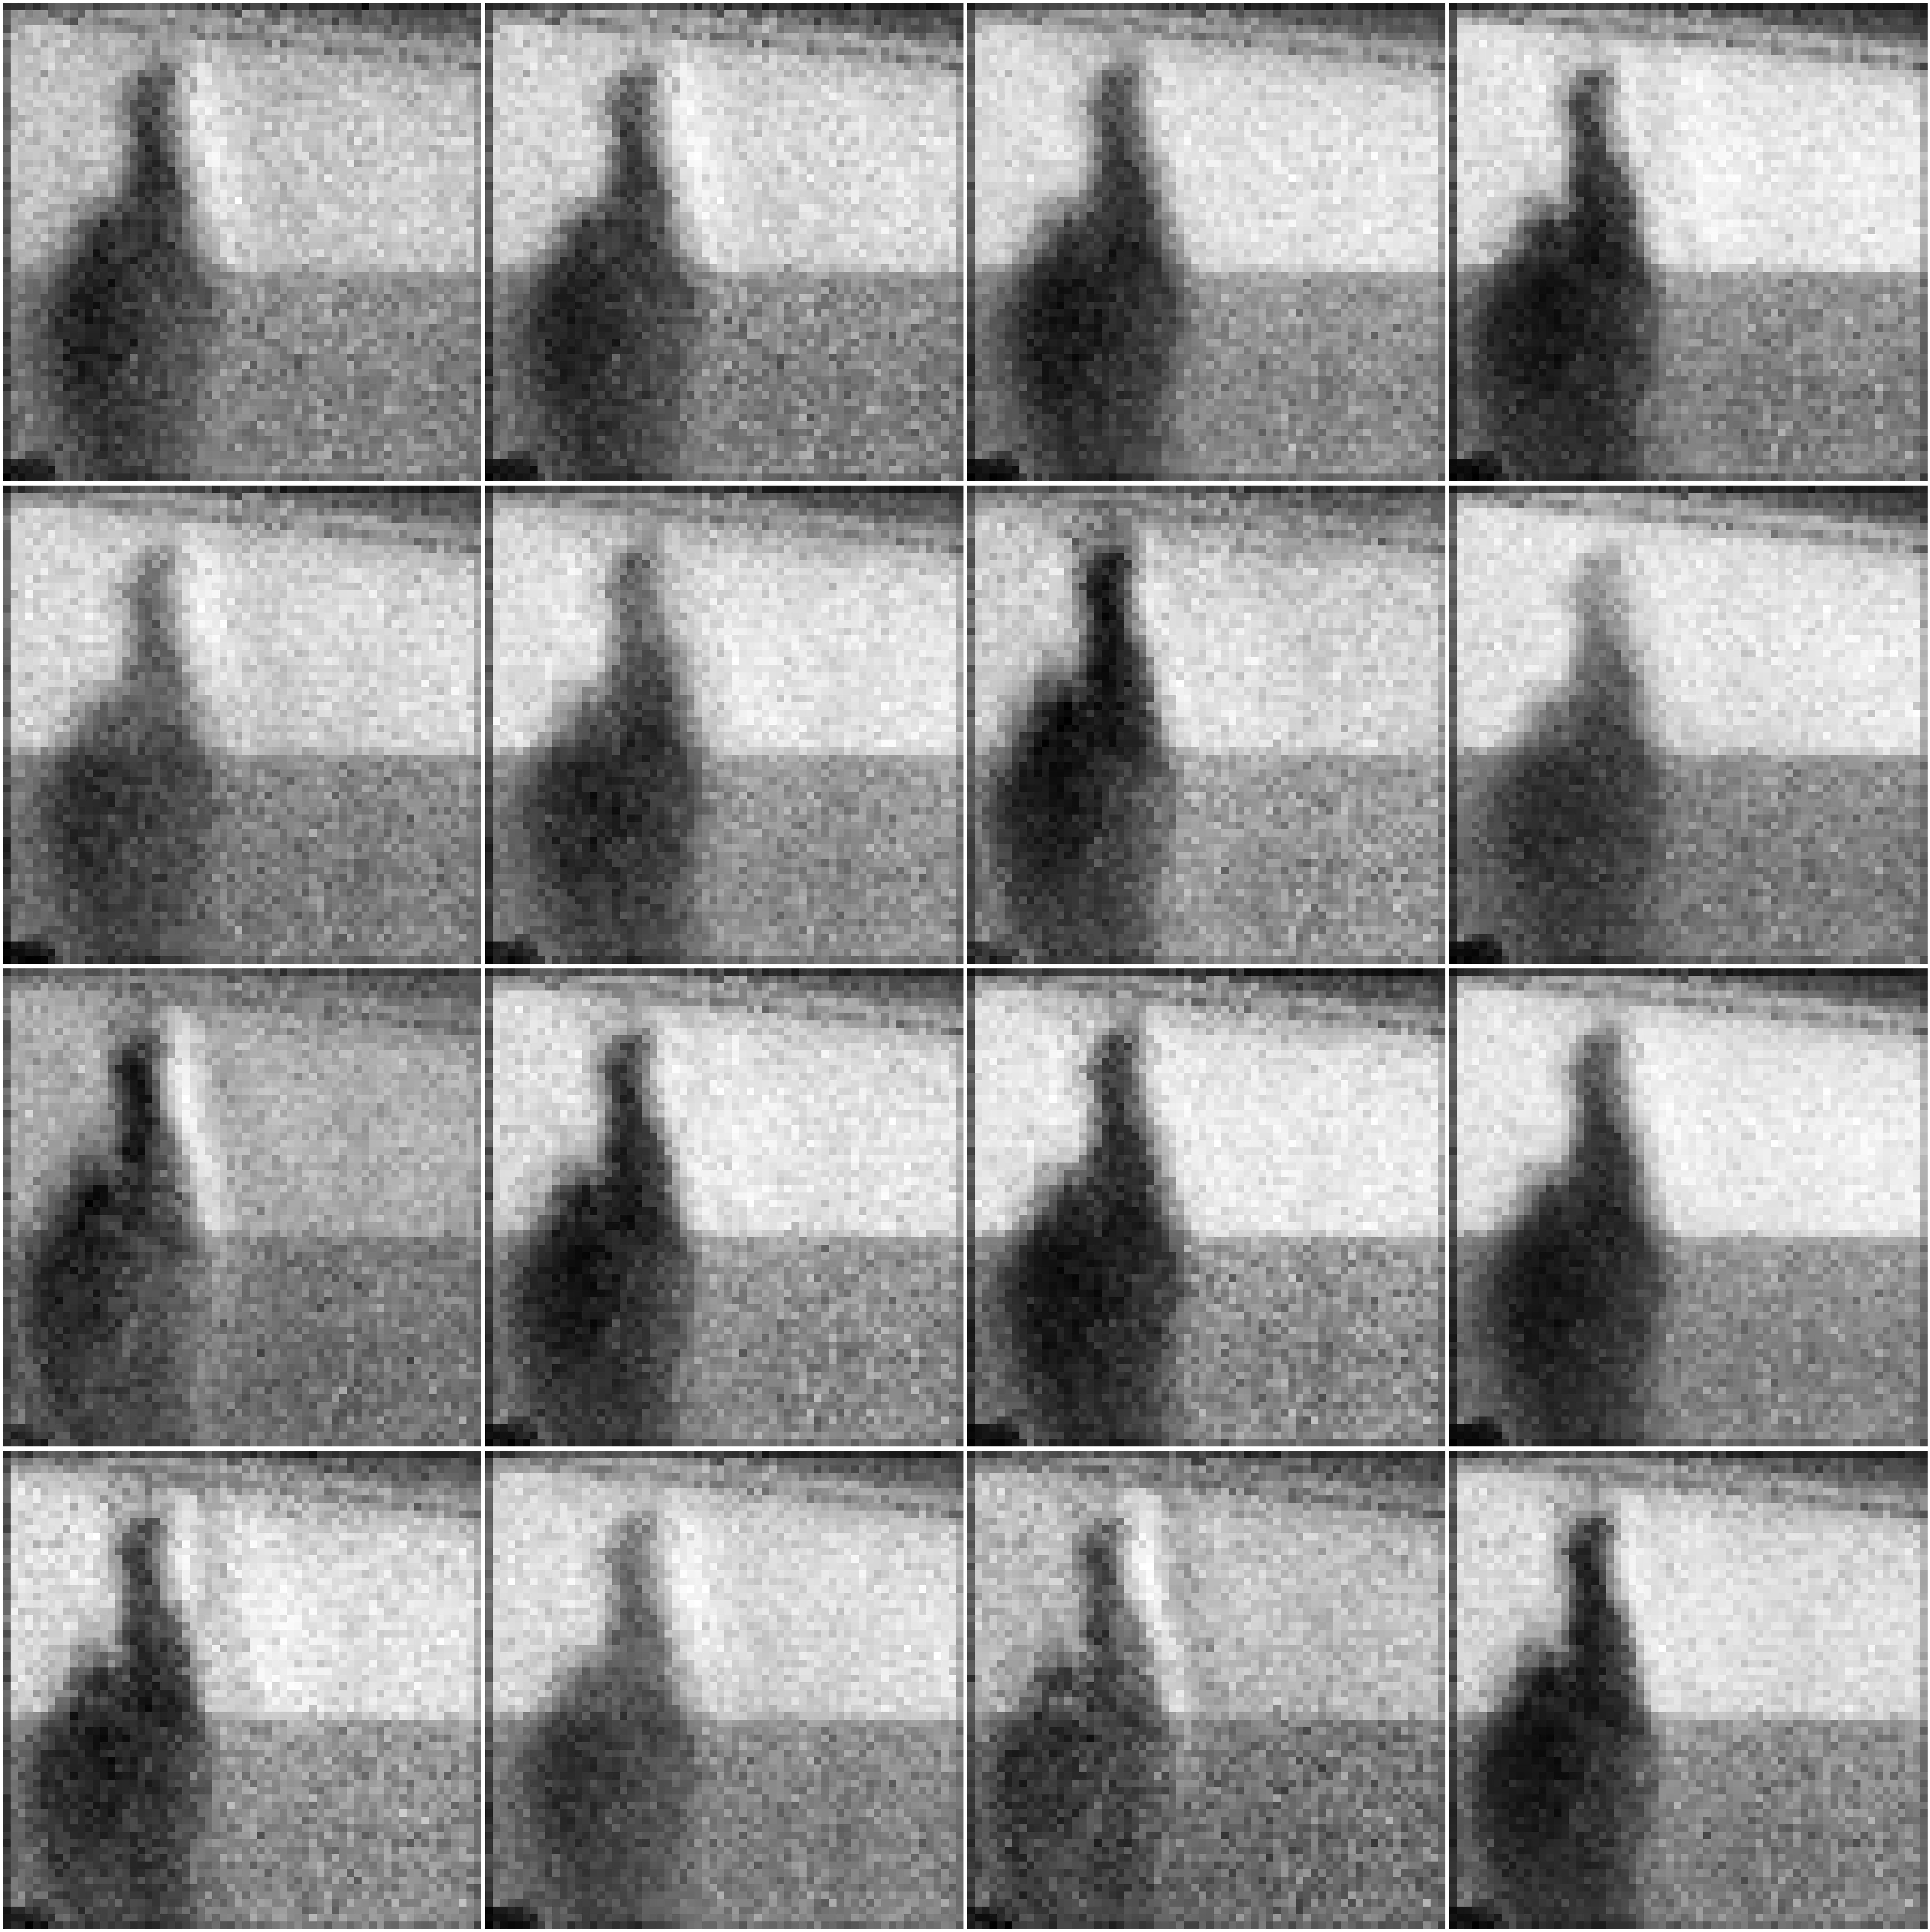

Starting training for letter: U
Completed Epoch 1/50, Epoch Duration: 6.63s, Total Loss D.: 0.0105, Total Loss G.: 6.2721
Completed Epoch 2/50, Epoch Duration: 6.86s, Total Loss D.: 0.0154, Total Loss G.: 5.8730
Completed Epoch 3/50, Epoch Duration: 6.63s, Total Loss D.: 0.1405, Total Loss G.: 4.8323
Completed Epoch 4/50, Epoch Duration: 6.46s, Total Loss D.: 0.1123, Total Loss G.: 12.2698
Completed Epoch 5/50, Epoch Duration: 6.82s, Total Loss D.: 0.0017, Total Loss G.: 9.0826
Completed Epoch 6/50, Epoch Duration: 6.73s, Total Loss D.: 0.0020, Total Loss G.: 7.0601
Completed Epoch 7/50, Epoch Duration: 6.80s, Total Loss D.: 0.0648, Total Loss G.: 4.3295
Completed Epoch 8/50, Epoch Duration: 6.90s, Total Loss D.: 0.0812, Total Loss G.: 4.5935
Completed Epoch 9/50, Epoch Duration: 6.84s, Total Loss D.: 0.0294, Total Loss G.: 4.5383
Completed Epoch 10/50, Epoch Duration: 6.71s, Total Loss D.: 0.0282, Total Loss G.: 8.5033
Completed Epoch 11/50, Epoch Duration: 6.78s, Total Loss D.: 0.131

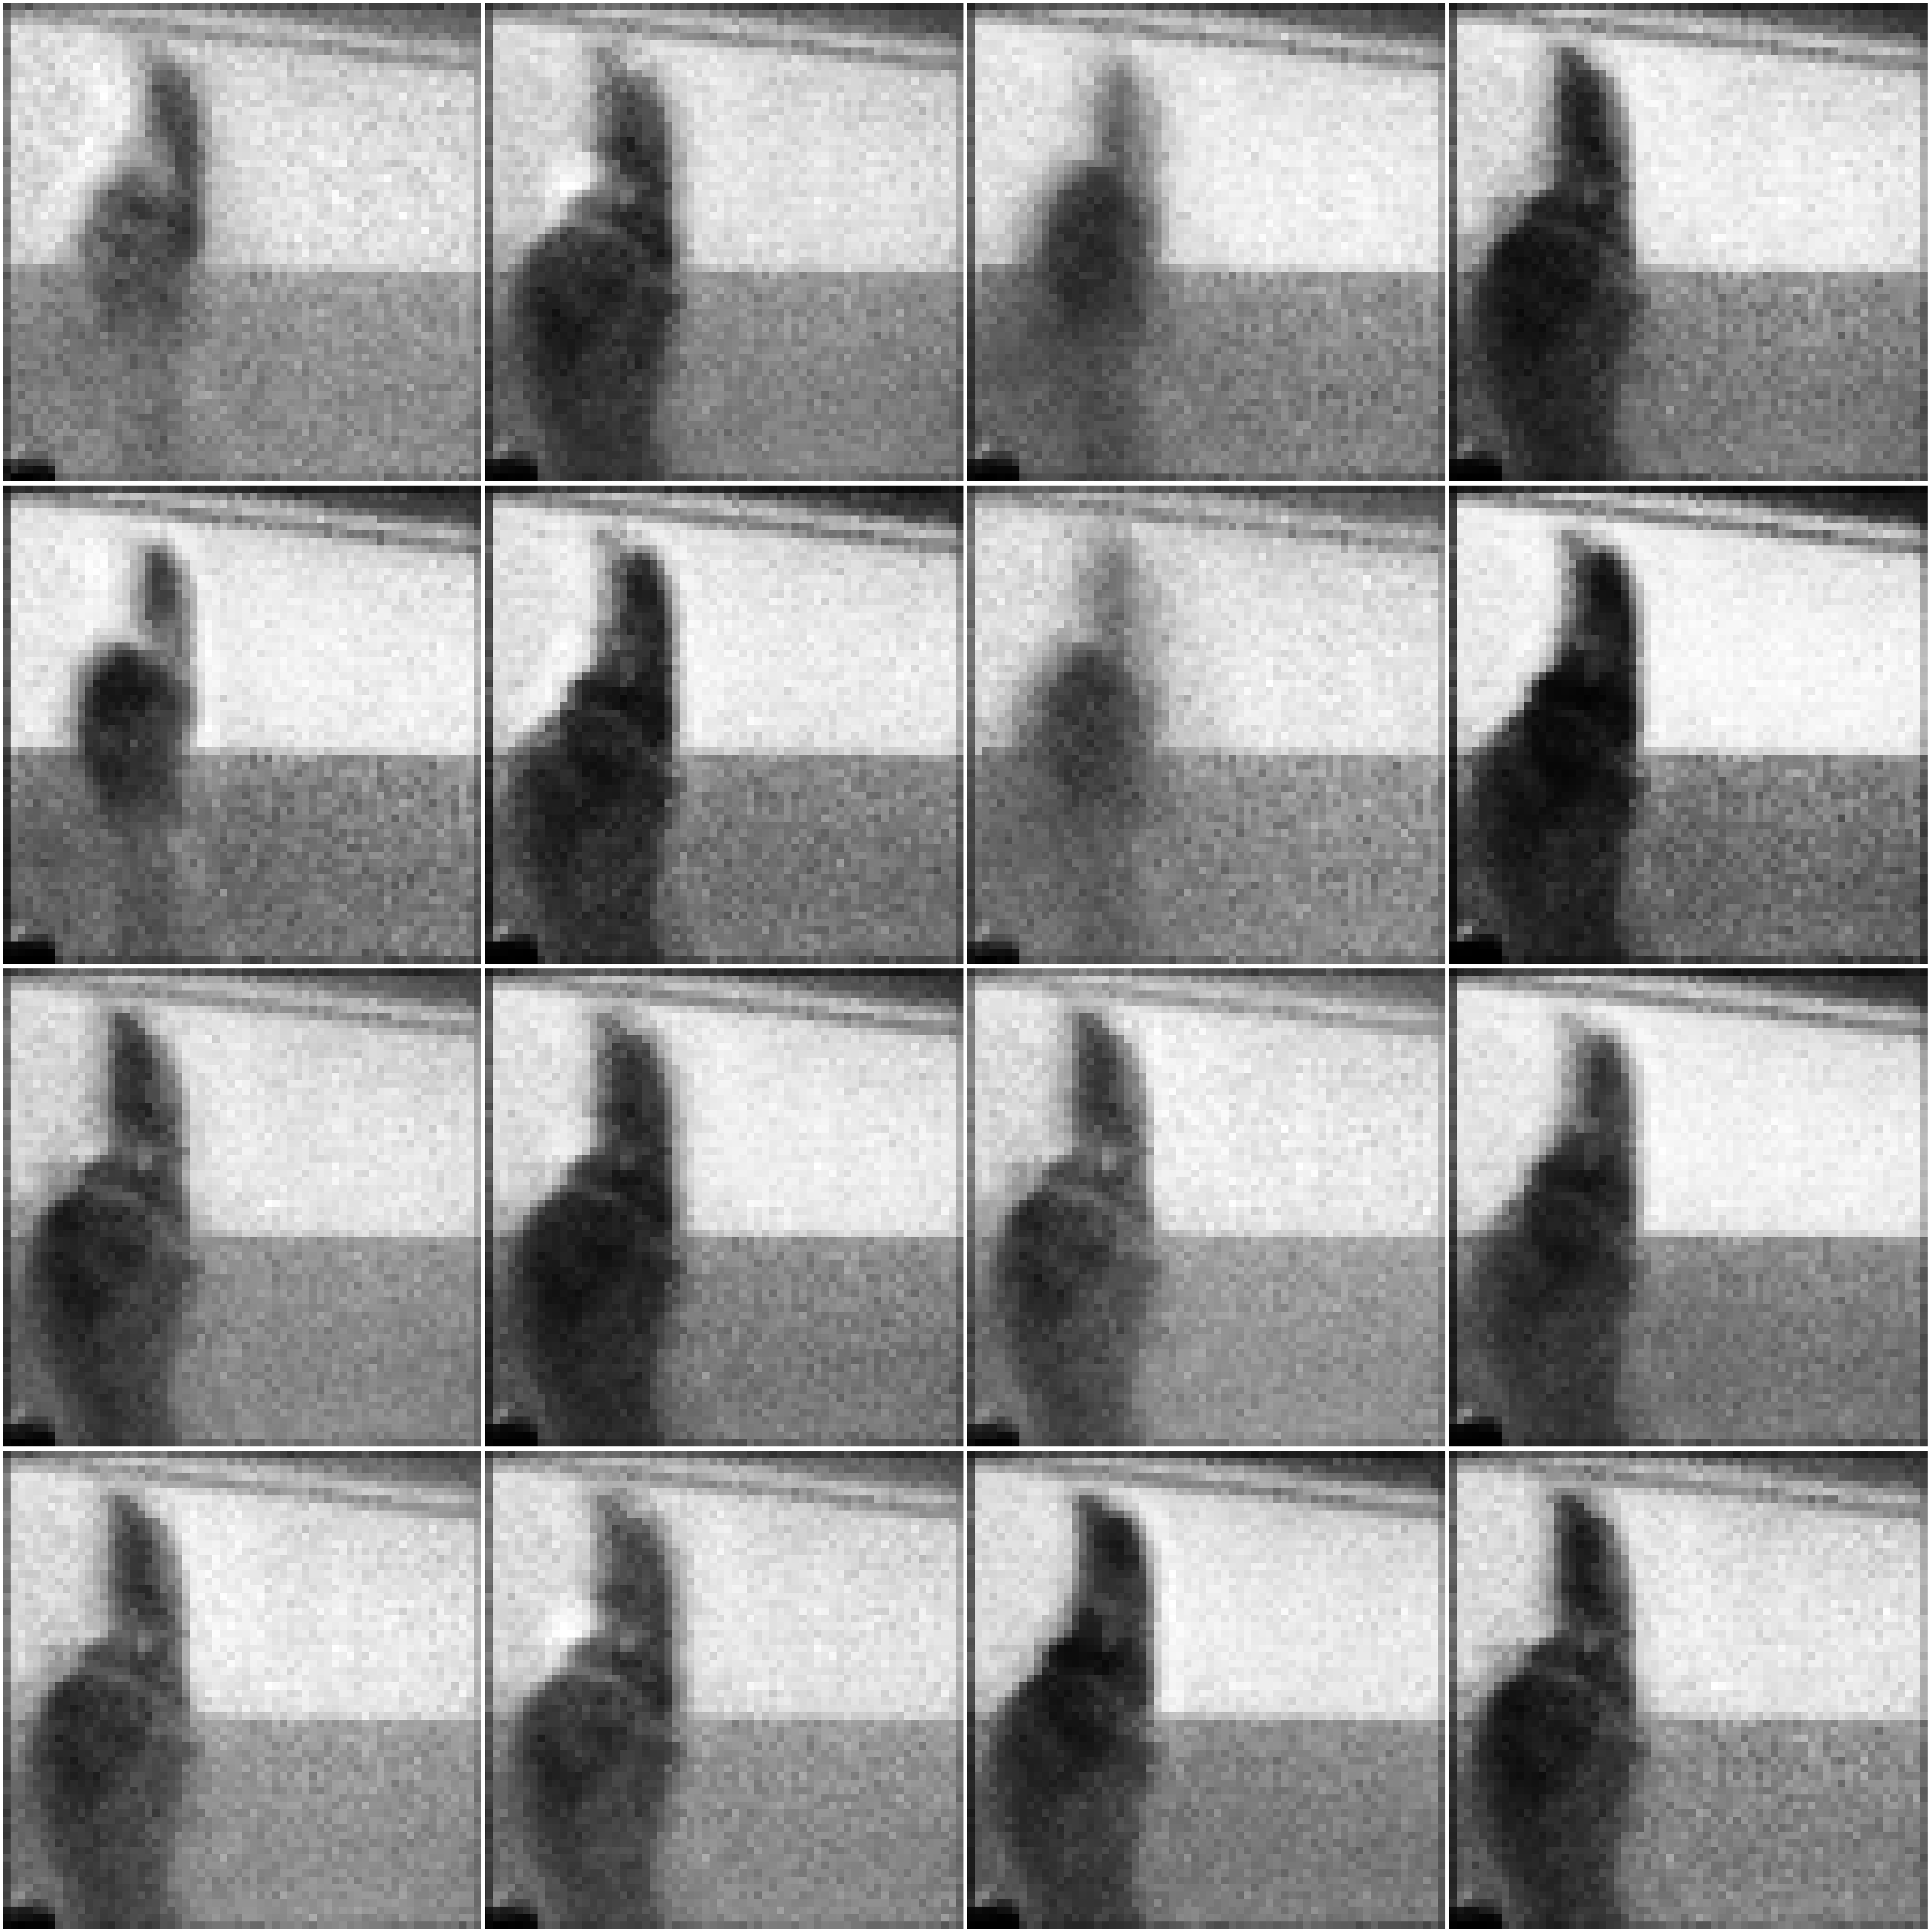

Starting training for letter: I
Completed Epoch 1/50, Epoch Duration: 7.62s, Total Loss D.: 0.0002, Total Loss G.: 9.2175
Completed Epoch 2/50, Epoch Duration: 6.88s, Total Loss D.: 0.0007, Total Loss G.: 8.9532
Completed Epoch 3/50, Epoch Duration: 6.87s, Total Loss D.: 0.0002, Total Loss G.: 22.6714
Completed Epoch 4/50, Epoch Duration: 6.85s, Total Loss D.: 0.0007, Total Loss G.: 20.0065
Completed Epoch 5/50, Epoch Duration: 6.92s, Total Loss D.: 0.0008, Total Loss G.: 8.6085
Completed Epoch 6/50, Epoch Duration: 6.91s, Total Loss D.: 0.0002, Total Loss G.: 13.3998
Completed Epoch 7/50, Epoch Duration: 6.86s, Total Loss D.: 0.0856, Total Loss G.: 3.7278
Completed Epoch 8/50, Epoch Duration: 7.03s, Total Loss D.: 0.0644, Total Loss G.: 3.9080
Completed Epoch 9/50, Epoch Duration: 7.05s, Total Loss D.: 0.0077, Total Loss G.: 4.2945
Completed Epoch 10/50, Epoch Duration: 7.09s, Total Loss D.: 0.0002, Total Loss G.: 11.7487
Completed Epoch 11/50, Epoch Duration: 6.95s, Total Loss D.: 0.

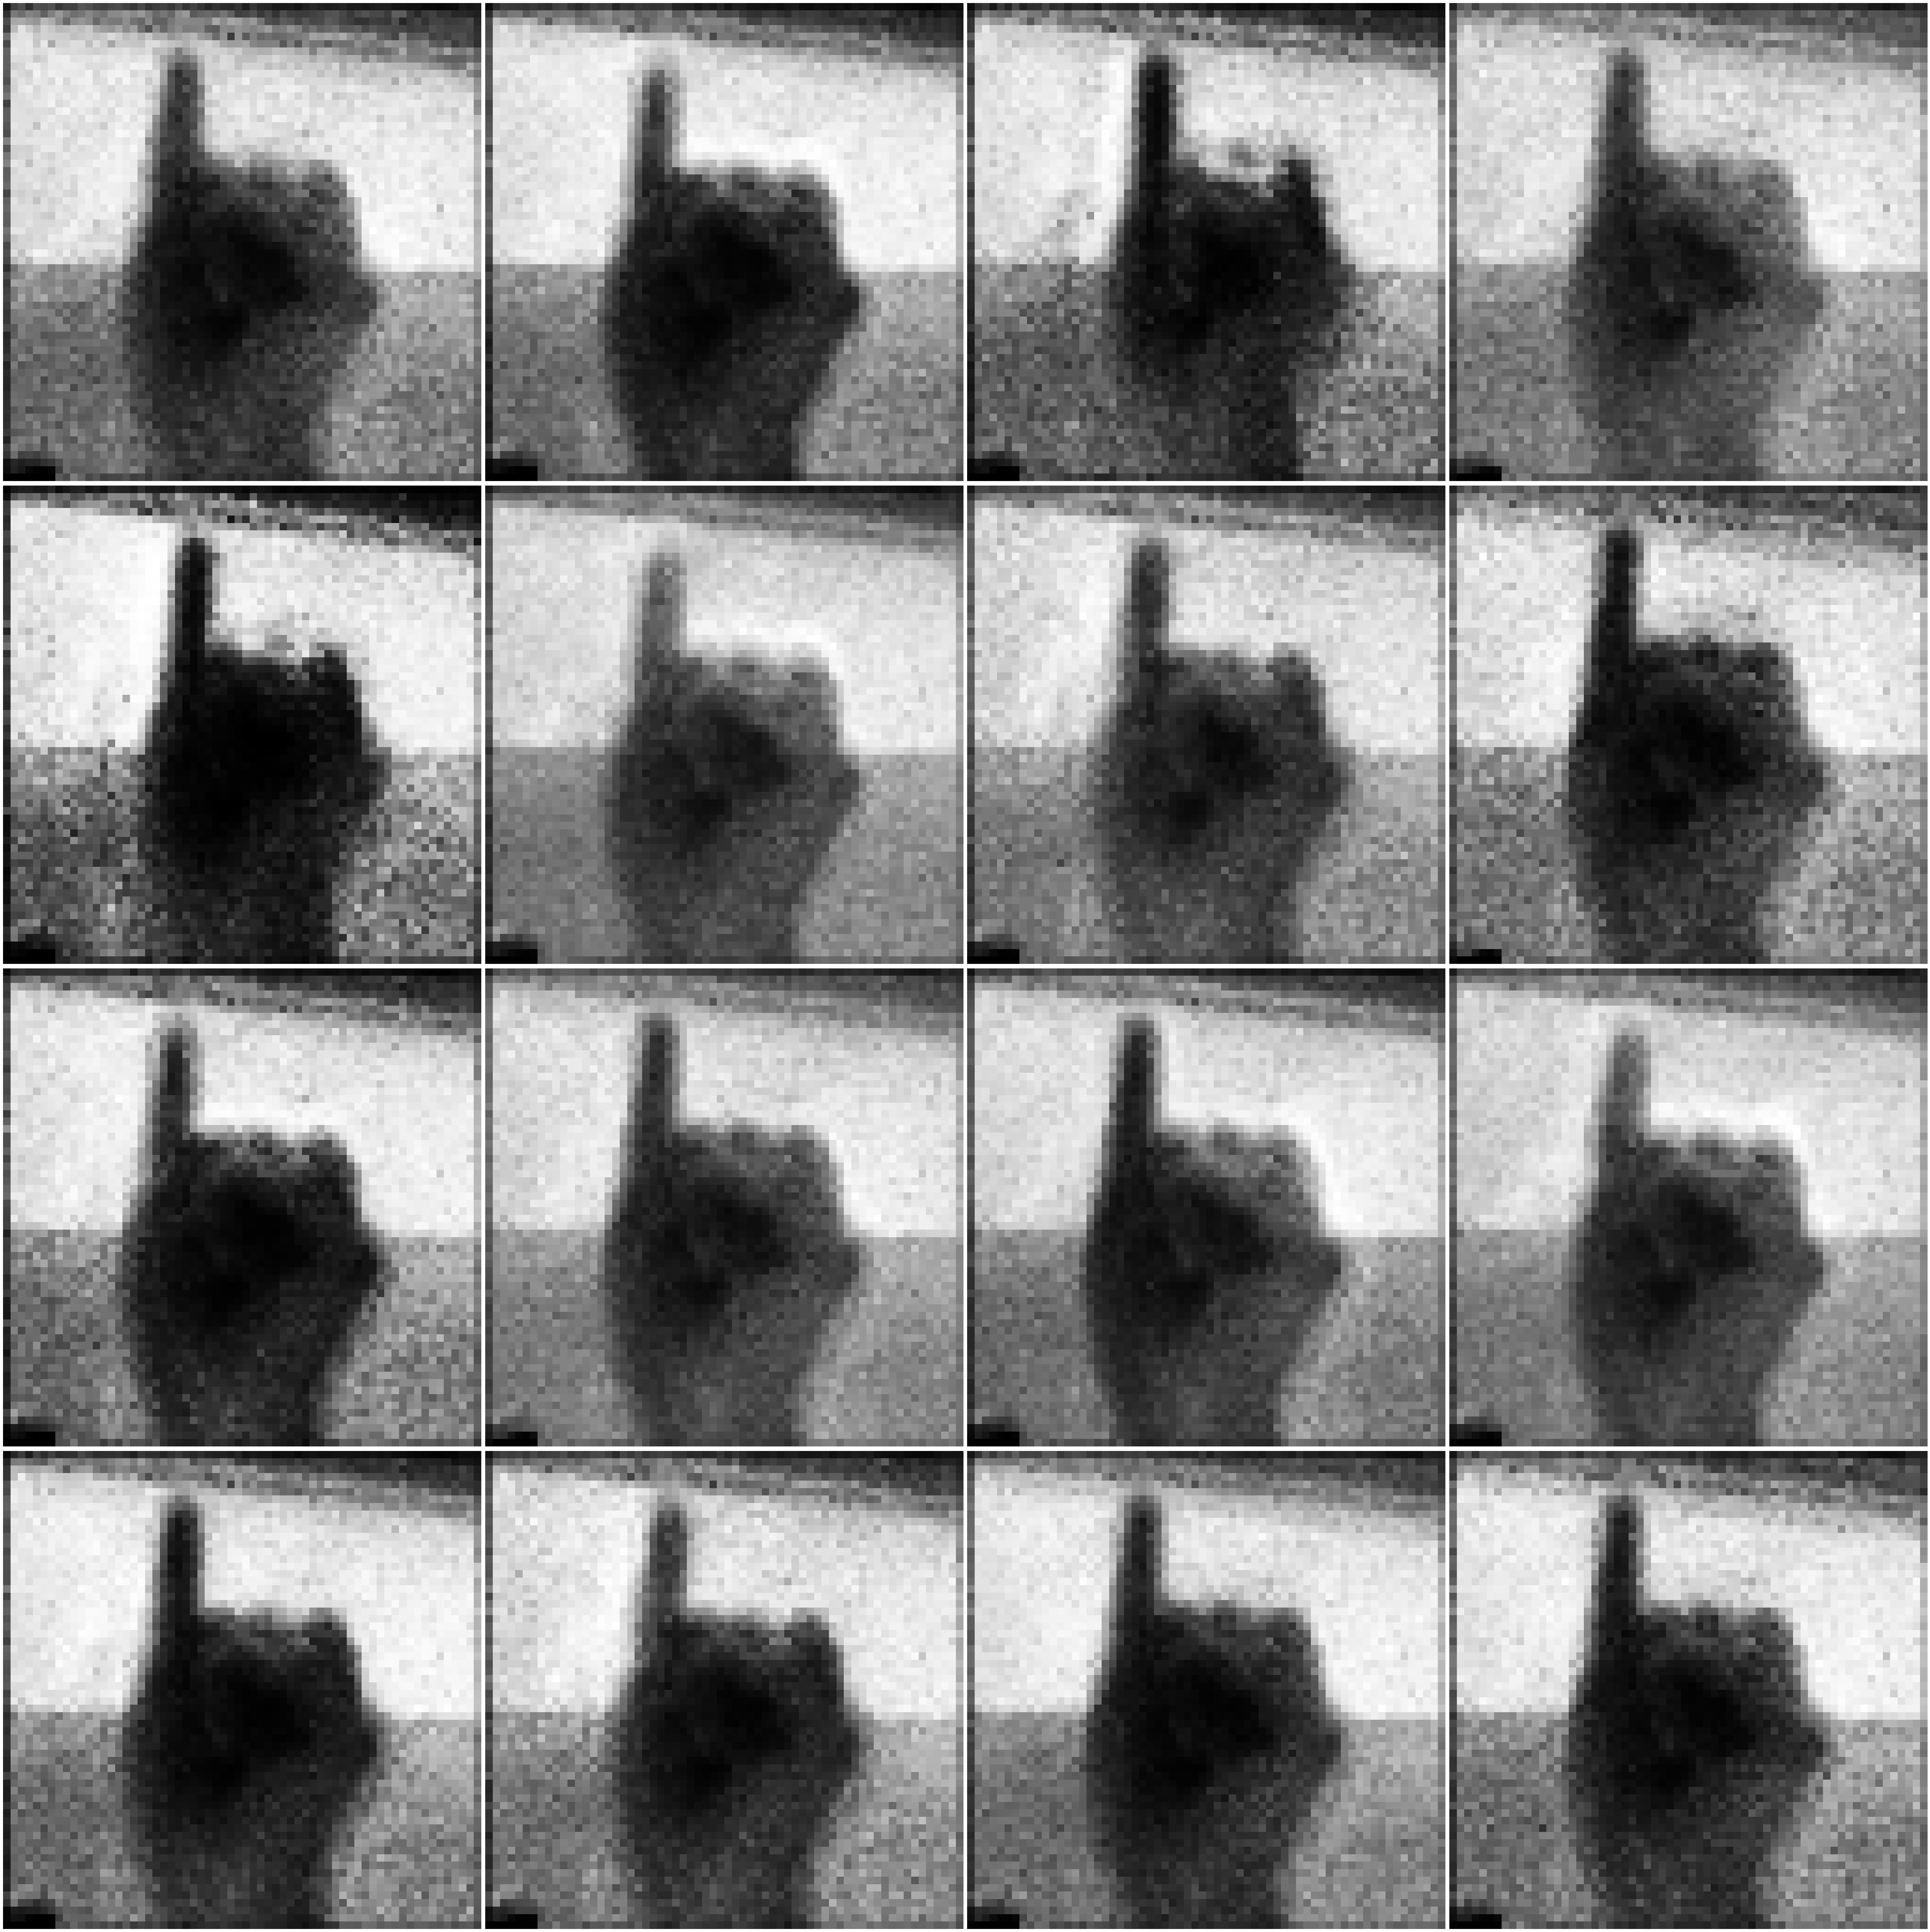

Starting training for letter: N
Completed Epoch 1/50, Epoch Duration: 7.51s, Total Loss D.: 0.0114, Total Loss G.: 7.6813
Completed Epoch 2/50, Epoch Duration: 7.12s, Total Loss D.: 0.0373, Total Loss G.: 10.5618
Completed Epoch 3/50, Epoch Duration: 6.82s, Total Loss D.: 0.0007, Total Loss G.: 8.0910
Completed Epoch 4/50, Epoch Duration: 6.84s, Total Loss D.: 0.0141, Total Loss G.: 4.3588
Completed Epoch 5/50, Epoch Duration: 6.84s, Total Loss D.: 0.0207, Total Loss G.: 8.4764
Completed Epoch 6/50, Epoch Duration: 6.83s, Total Loss D.: 0.0017, Total Loss G.: 6.2430
Completed Epoch 7/50, Epoch Duration: 6.81s, Total Loss D.: 0.1010, Total Loss G.: 8.1267
Completed Epoch 8/50, Epoch Duration: 6.76s, Total Loss D.: 0.0135, Total Loss G.: 6.3901
Completed Epoch 9/50, Epoch Duration: 6.75s, Total Loss D.: 0.0249, Total Loss G.: 6.3801
Completed Epoch 10/50, Epoch Duration: 7.01s, Total Loss D.: 0.0009, Total Loss G.: 4.9910
Completed Epoch 11/50, Epoch Duration: 6.87s, Total Loss D.: 0.007

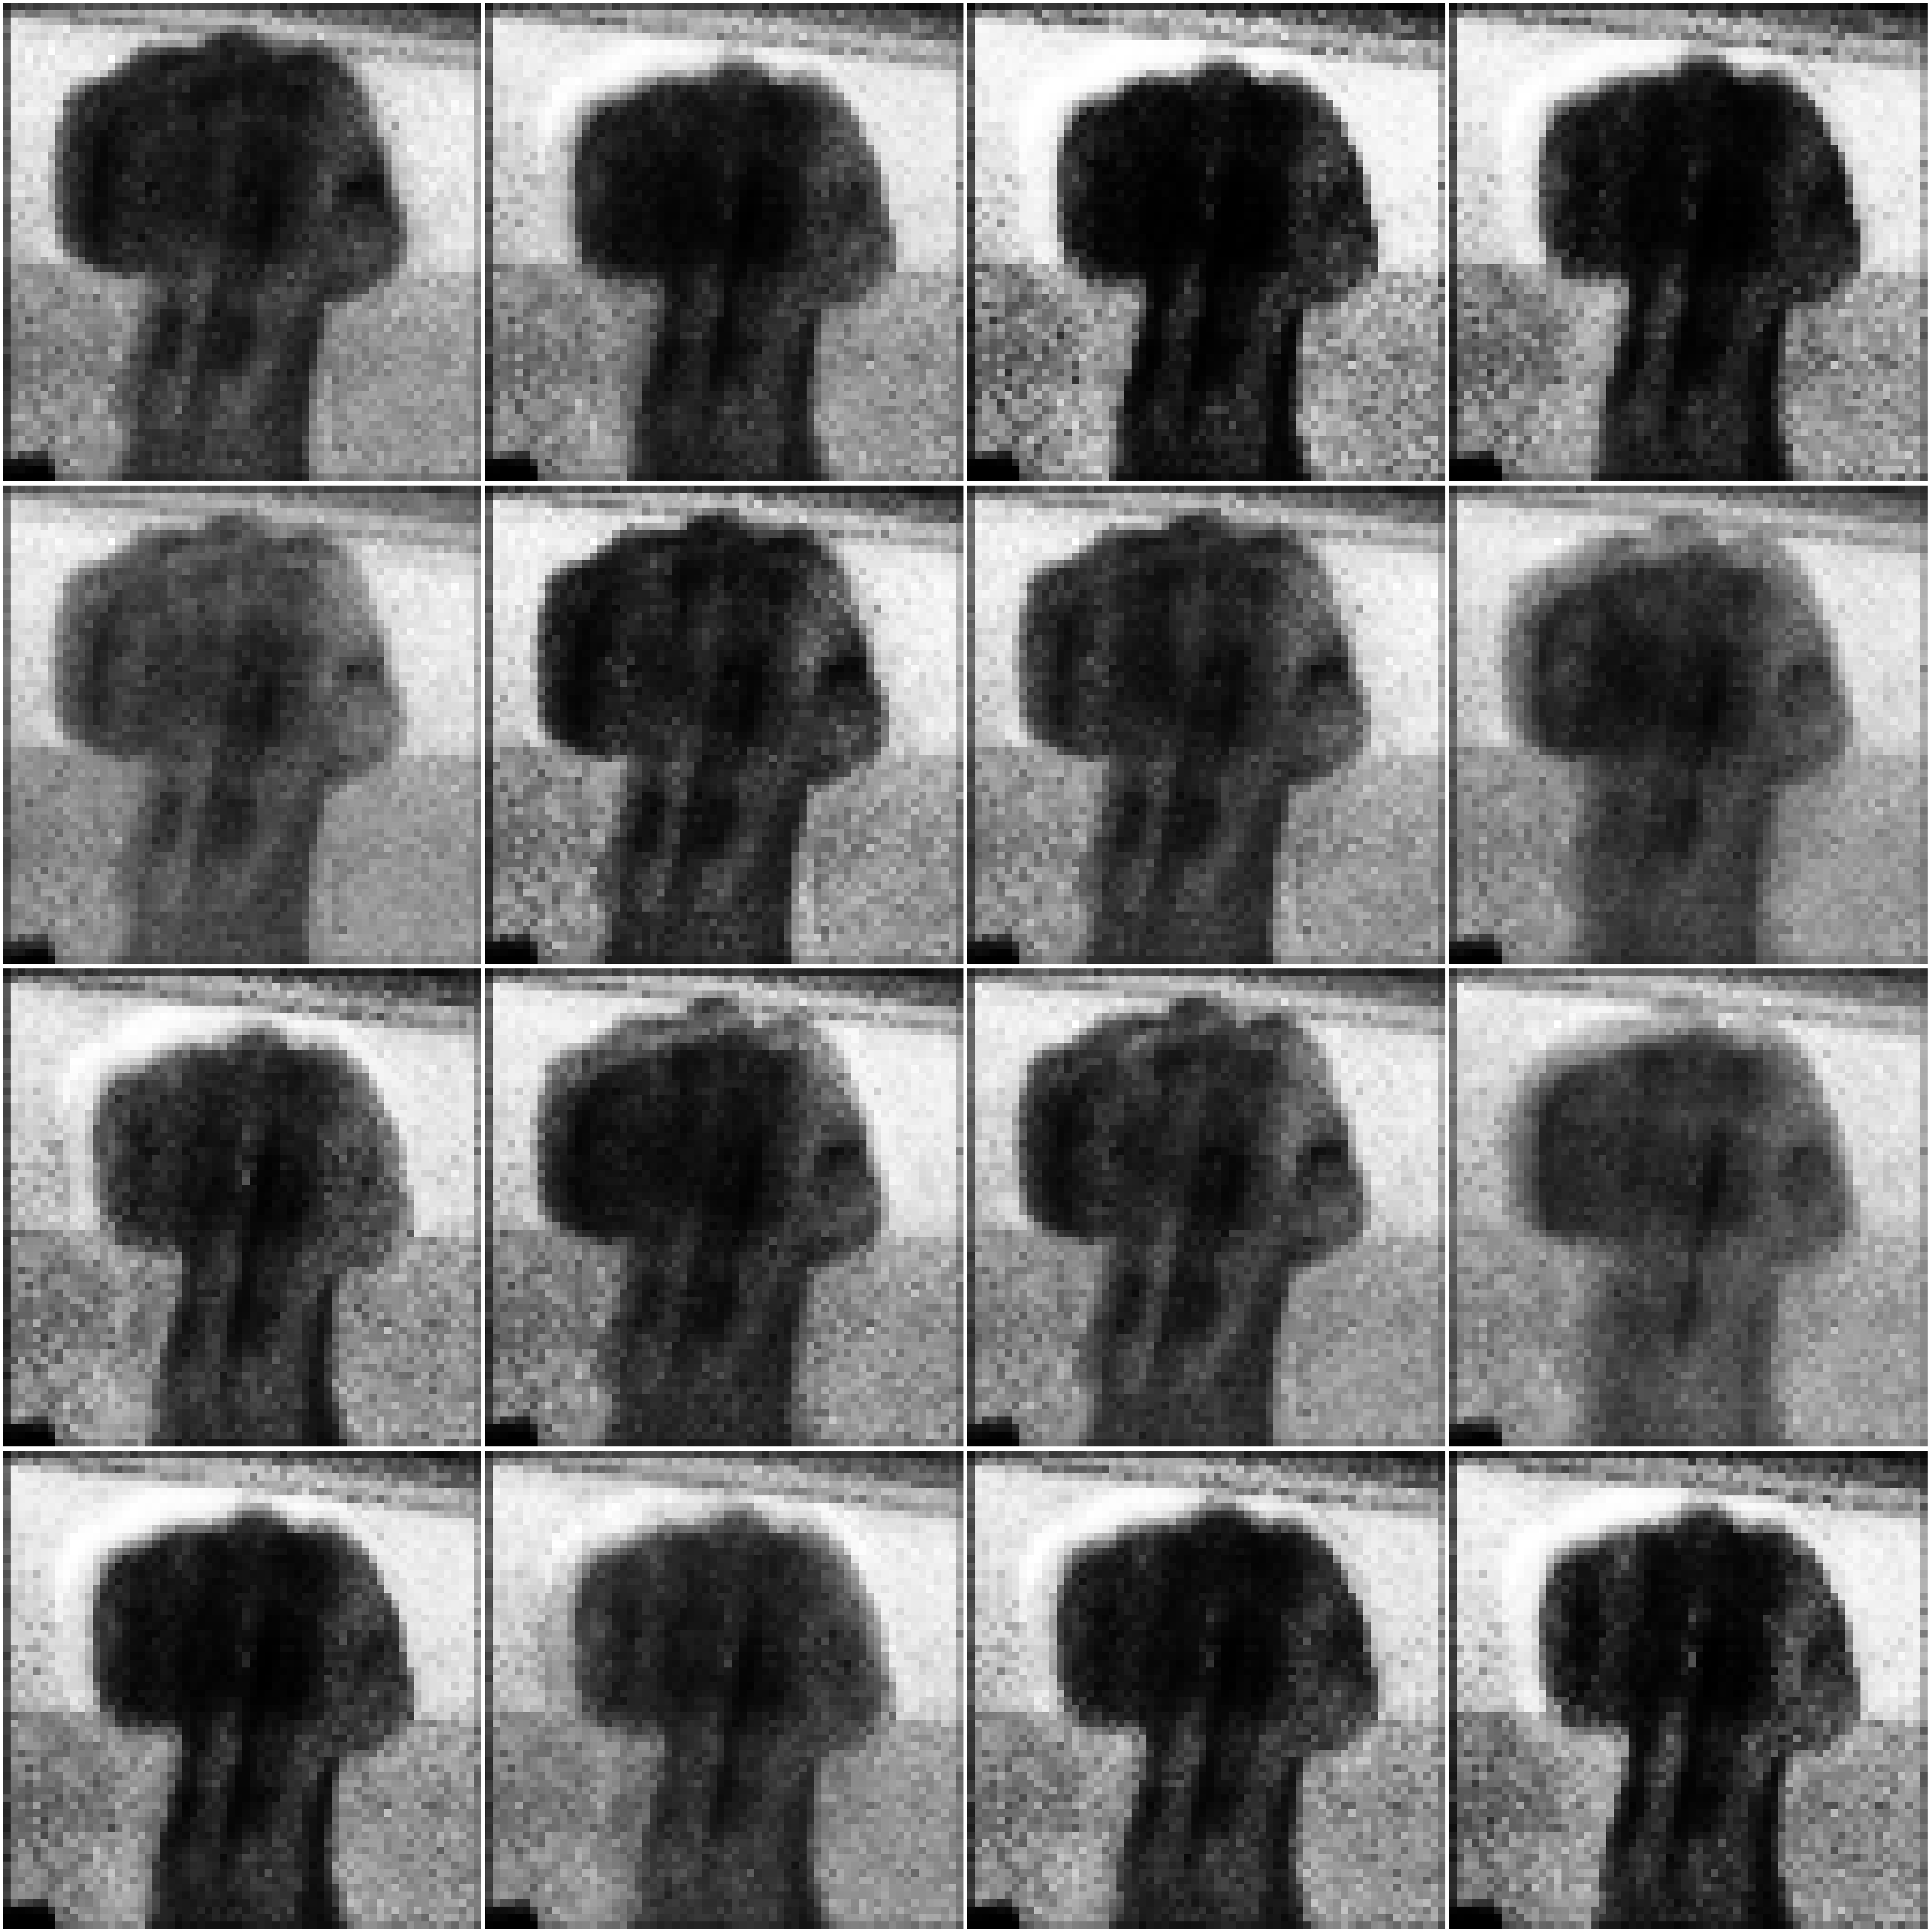

Starting training for letter: G
Completed Epoch 1/50, Epoch Duration: 7.36s, Total Loss D.: 0.0002, Total Loss G.: 9.2920
Completed Epoch 2/50, Epoch Duration: 7.01s, Total Loss D.: 0.0046, Total Loss G.: 10.7910
Completed Epoch 3/50, Epoch Duration: 6.84s, Total Loss D.: 0.0036, Total Loss G.: 8.7810
Completed Epoch 4/50, Epoch Duration: 7.09s, Total Loss D.: 0.0233, Total Loss G.: 5.5325
Completed Epoch 5/50, Epoch Duration: 6.79s, Total Loss D.: 0.0174, Total Loss G.: 5.6126
Completed Epoch 6/50, Epoch Duration: 6.75s, Total Loss D.: 0.0592, Total Loss G.: 5.8849
Completed Epoch 7/50, Epoch Duration: 6.81s, Total Loss D.: 0.1001, Total Loss G.: 5.7176
Completed Epoch 8/50, Epoch Duration: 6.90s, Total Loss D.: 0.0851, Total Loss G.: 6.3359
Completed Epoch 9/50, Epoch Duration: 6.75s, Total Loss D.: 0.0104, Total Loss G.: 7.0586
Completed Epoch 10/50, Epoch Duration: 6.78s, Total Loss D.: 0.0387, Total Loss G.: 4.0071
Completed Epoch 11/50, Epoch Duration: 6.78s, Total Loss D.: 0.124

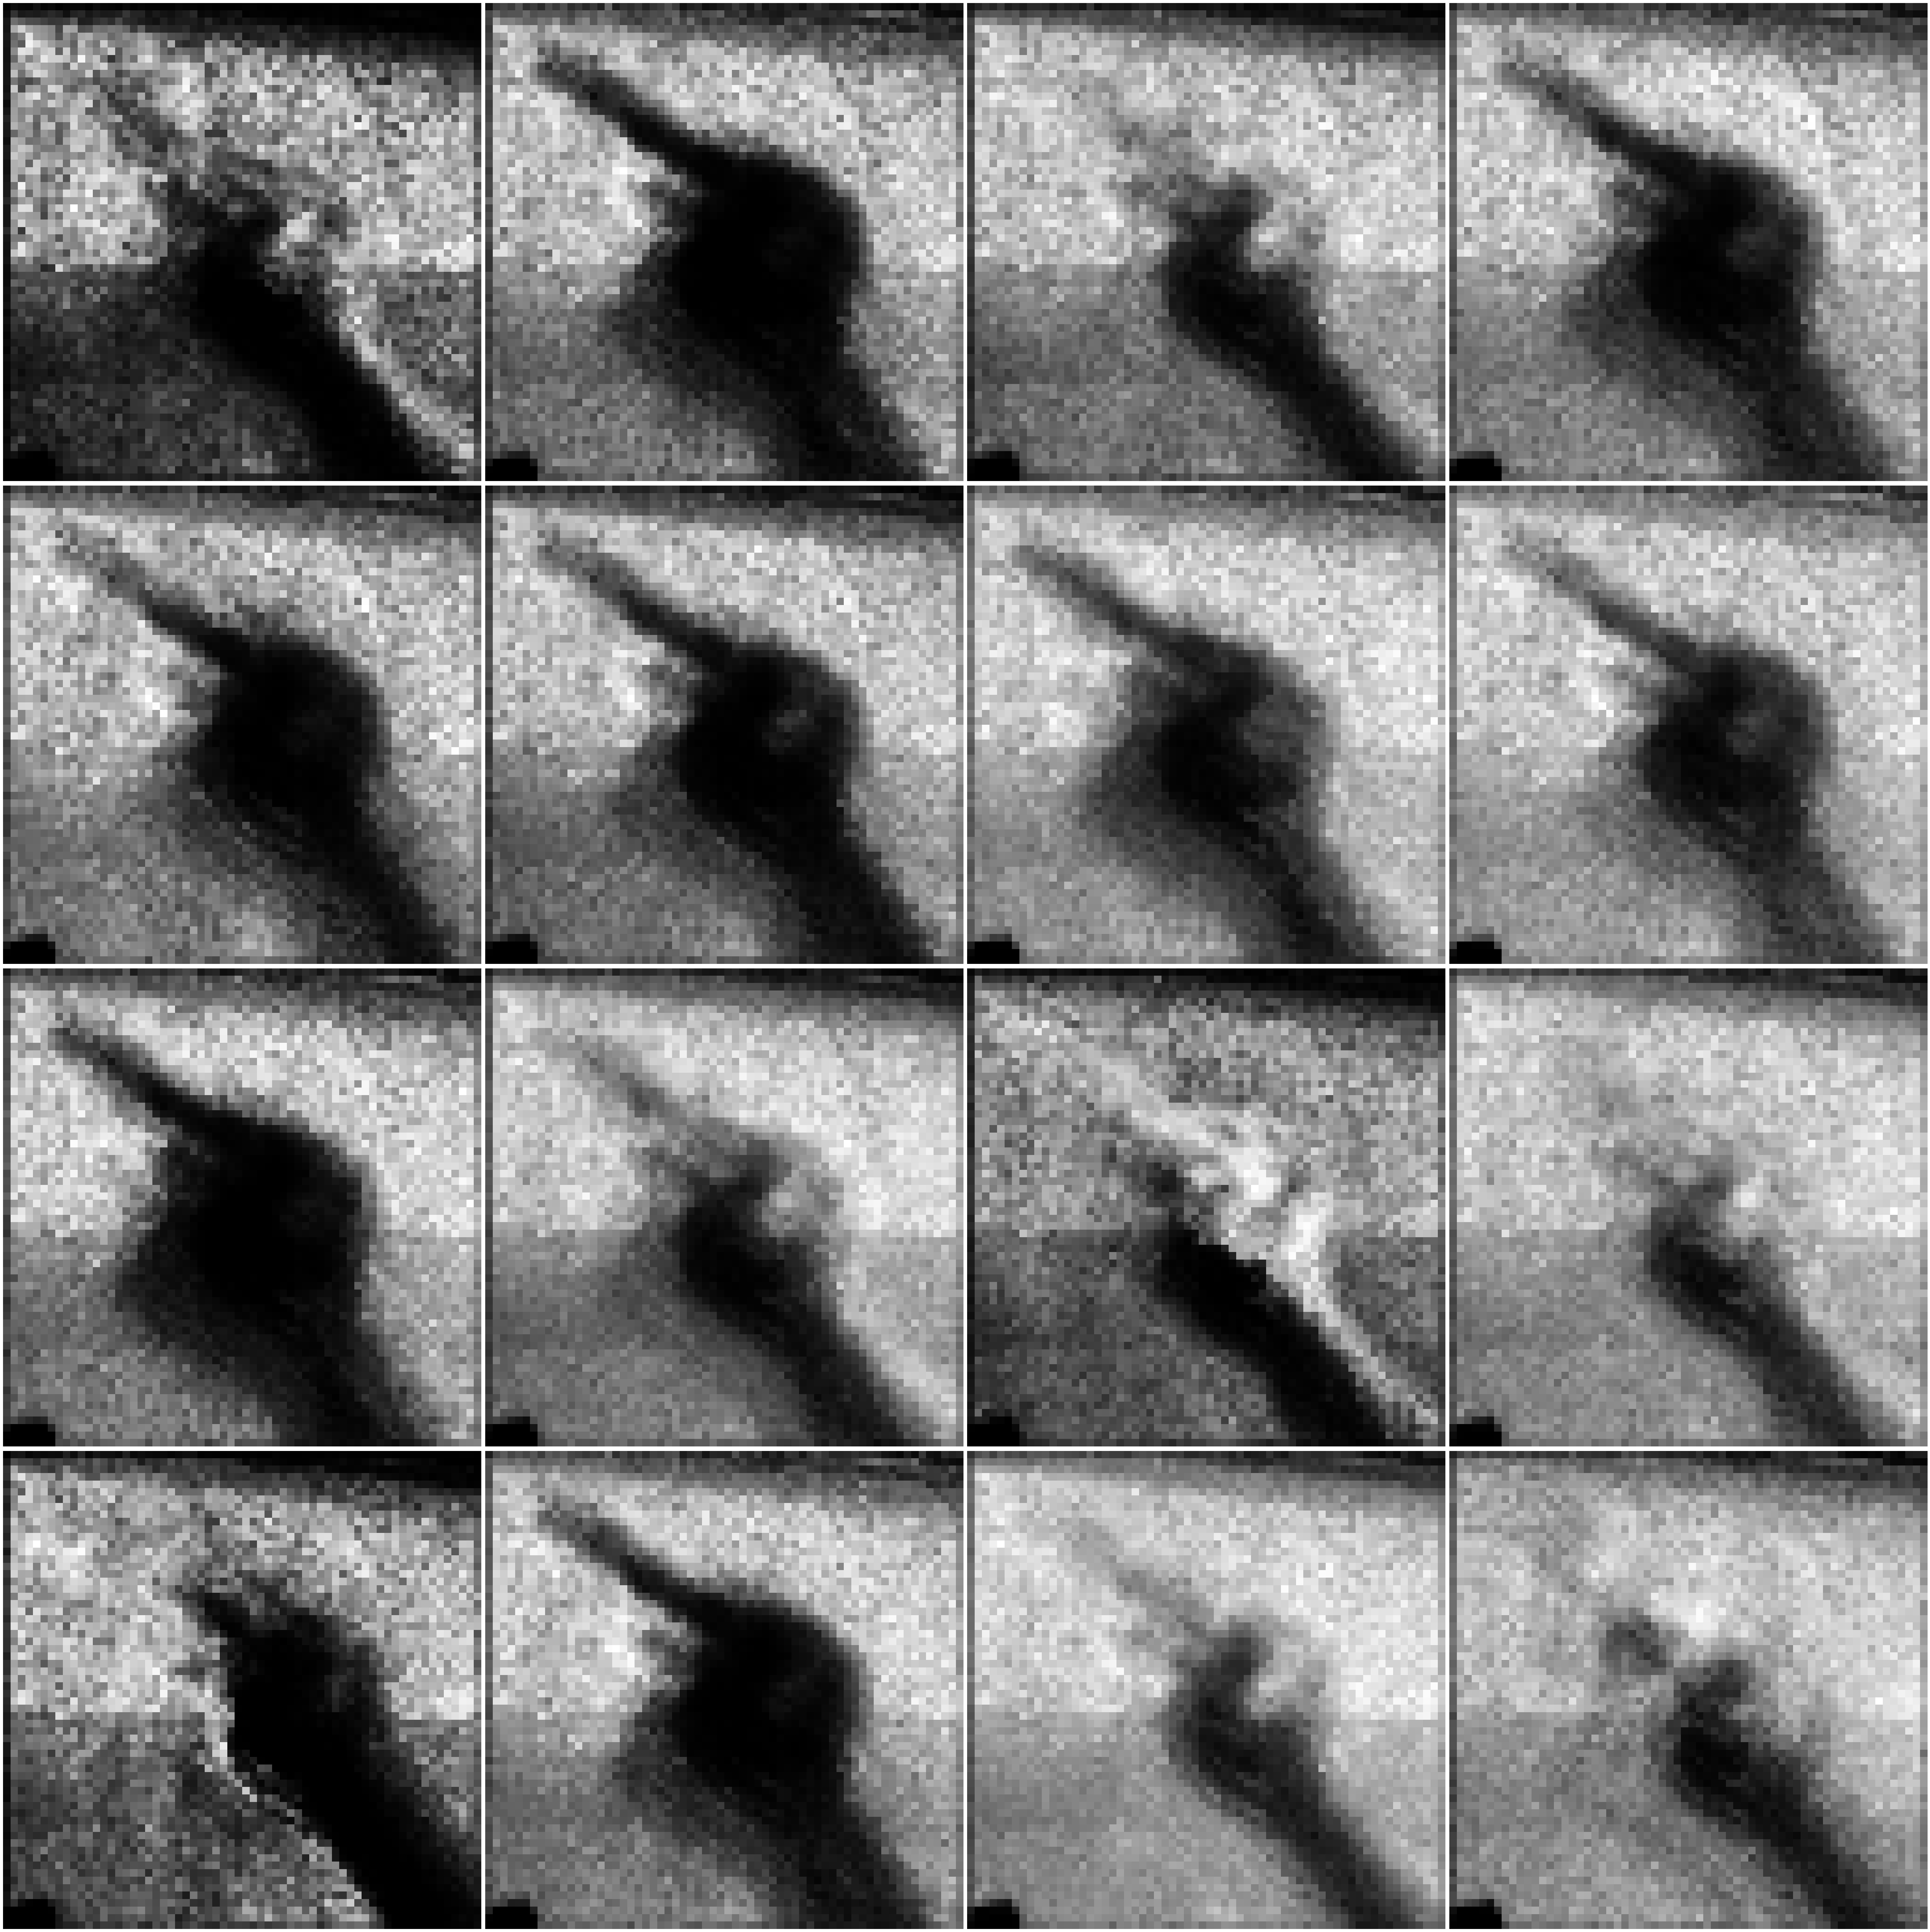

Starting training for letter: Z
Completed Epoch 1/50, Epoch Duration: 7.36s, Total Loss D.: 0.0012, Total Loss G.: 7.8314
Completed Epoch 2/50, Epoch Duration: 7.17s, Total Loss D.: 0.0293, Total Loss G.: 9.7949
Completed Epoch 3/50, Epoch Duration: 6.81s, Total Loss D.: 0.0799, Total Loss G.: 7.4277
Completed Epoch 4/50, Epoch Duration: 6.82s, Total Loss D.: 0.0269, Total Loss G.: 6.2657
Completed Epoch 5/50, Epoch Duration: 6.79s, Total Loss D.: 0.0023, Total Loss G.: 8.2336
Completed Epoch 6/50, Epoch Duration: 6.94s, Total Loss D.: 0.0155, Total Loss G.: 5.9640
Completed Epoch 7/50, Epoch Duration: 6.83s, Total Loss D.: 0.0678, Total Loss G.: 6.7956
Completed Epoch 8/50, Epoch Duration: 6.82s, Total Loss D.: 0.0170, Total Loss G.: 6.0482
Completed Epoch 9/50, Epoch Duration: 6.76s, Total Loss D.: 0.0387, Total Loss G.: 6.8896
Completed Epoch 10/50, Epoch Duration: 7.29s, Total Loss D.: 0.0820, Total Loss G.: 8.4169
Completed Epoch 11/50, Epoch Duration: 6.84s, Total Loss D.: 0.0492

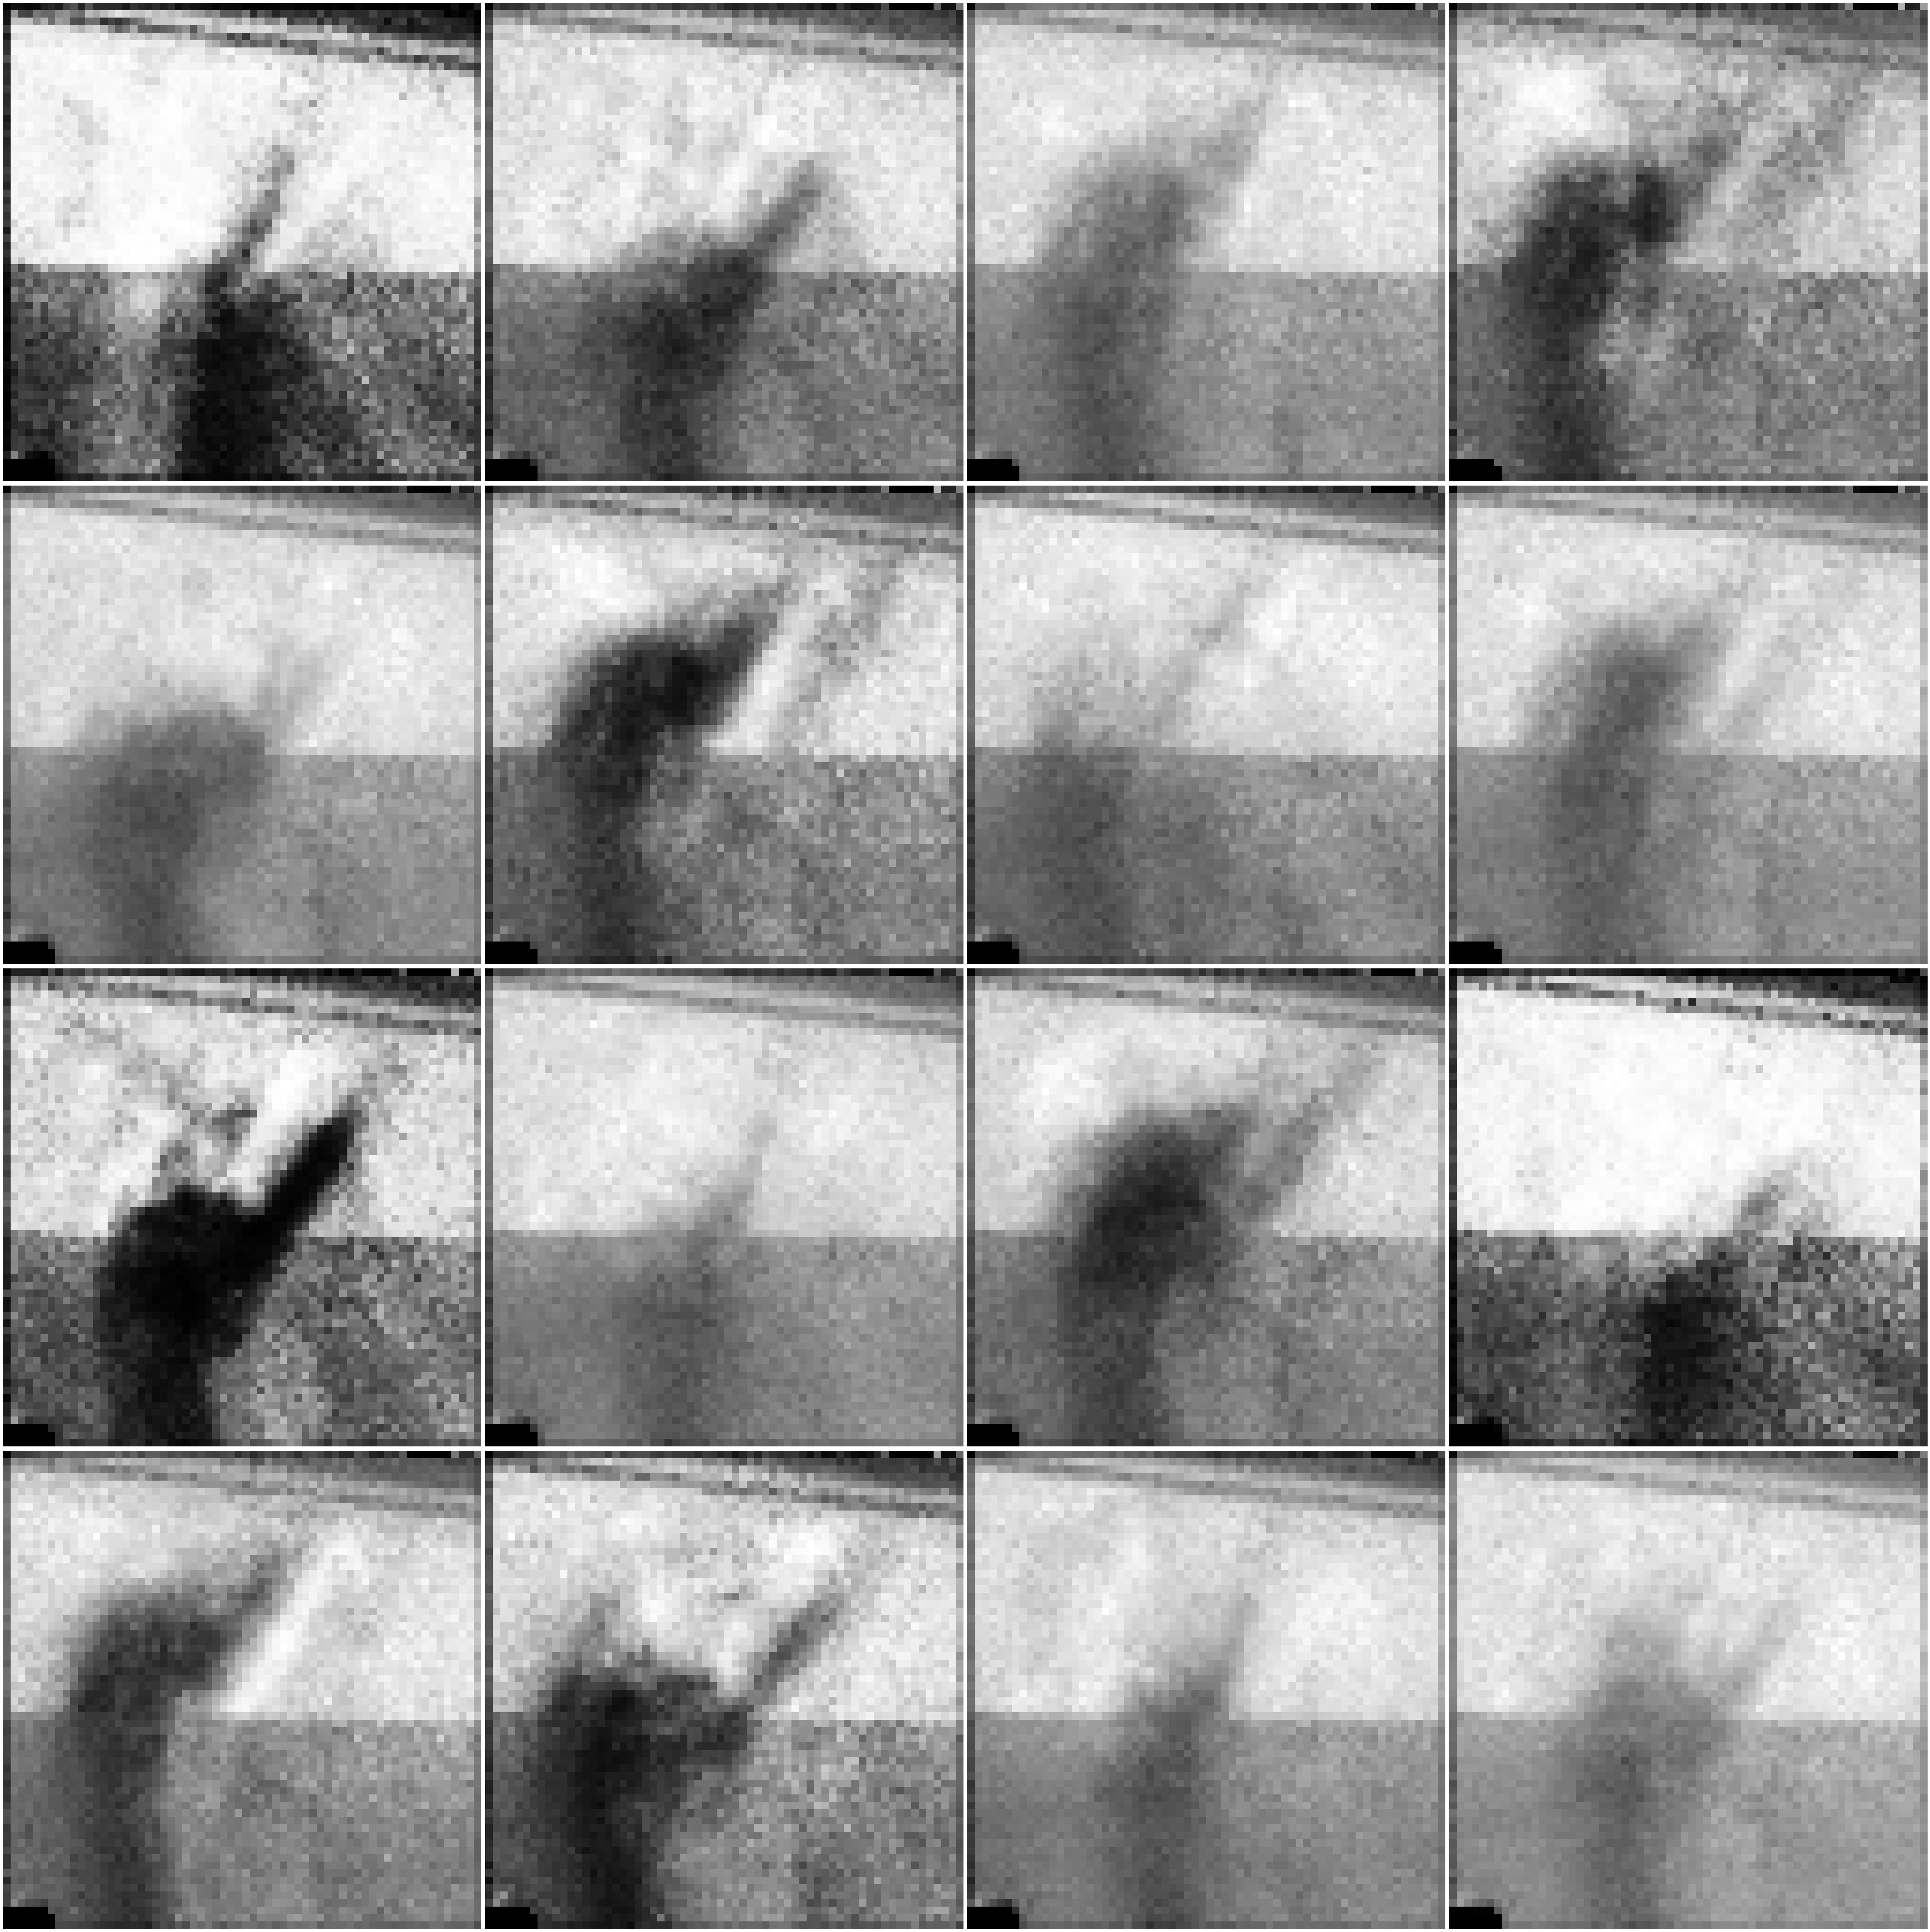

Starting training for letter: T
Completed Epoch 1/50, Epoch Duration: 7.57s, Total Loss D.: 0.0294, Total Loss G.: 6.4316
Completed Epoch 2/50, Epoch Duration: 7.05s, Total Loss D.: 0.0246, Total Loss G.: 4.6773
Completed Epoch 3/50, Epoch Duration: 6.81s, Total Loss D.: 0.0070, Total Loss G.: 5.6804
Completed Epoch 4/50, Epoch Duration: 6.89s, Total Loss D.: 0.0074, Total Loss G.: 6.1816
Completed Epoch 5/50, Epoch Duration: 6.80s, Total Loss D.: 0.0033, Total Loss G.: 6.9458
Completed Epoch 6/50, Epoch Duration: 6.78s, Total Loss D.: 0.0727, Total Loss G.: 4.9979
Completed Epoch 7/50, Epoch Duration: 6.78s, Total Loss D.: 0.0490, Total Loss G.: 6.1663
Completed Epoch 8/50, Epoch Duration: 6.96s, Total Loss D.: 0.0121, Total Loss G.: 6.0833
Completed Epoch 9/50, Epoch Duration: 6.84s, Total Loss D.: 0.0574, Total Loss G.: 5.1176
Completed Epoch 10/50, Epoch Duration: 6.86s, Total Loss D.: 0.0068, Total Loss G.: 6.6276
Completed Epoch 11/50, Epoch Duration: 6.76s, Total Loss D.: 0.1638

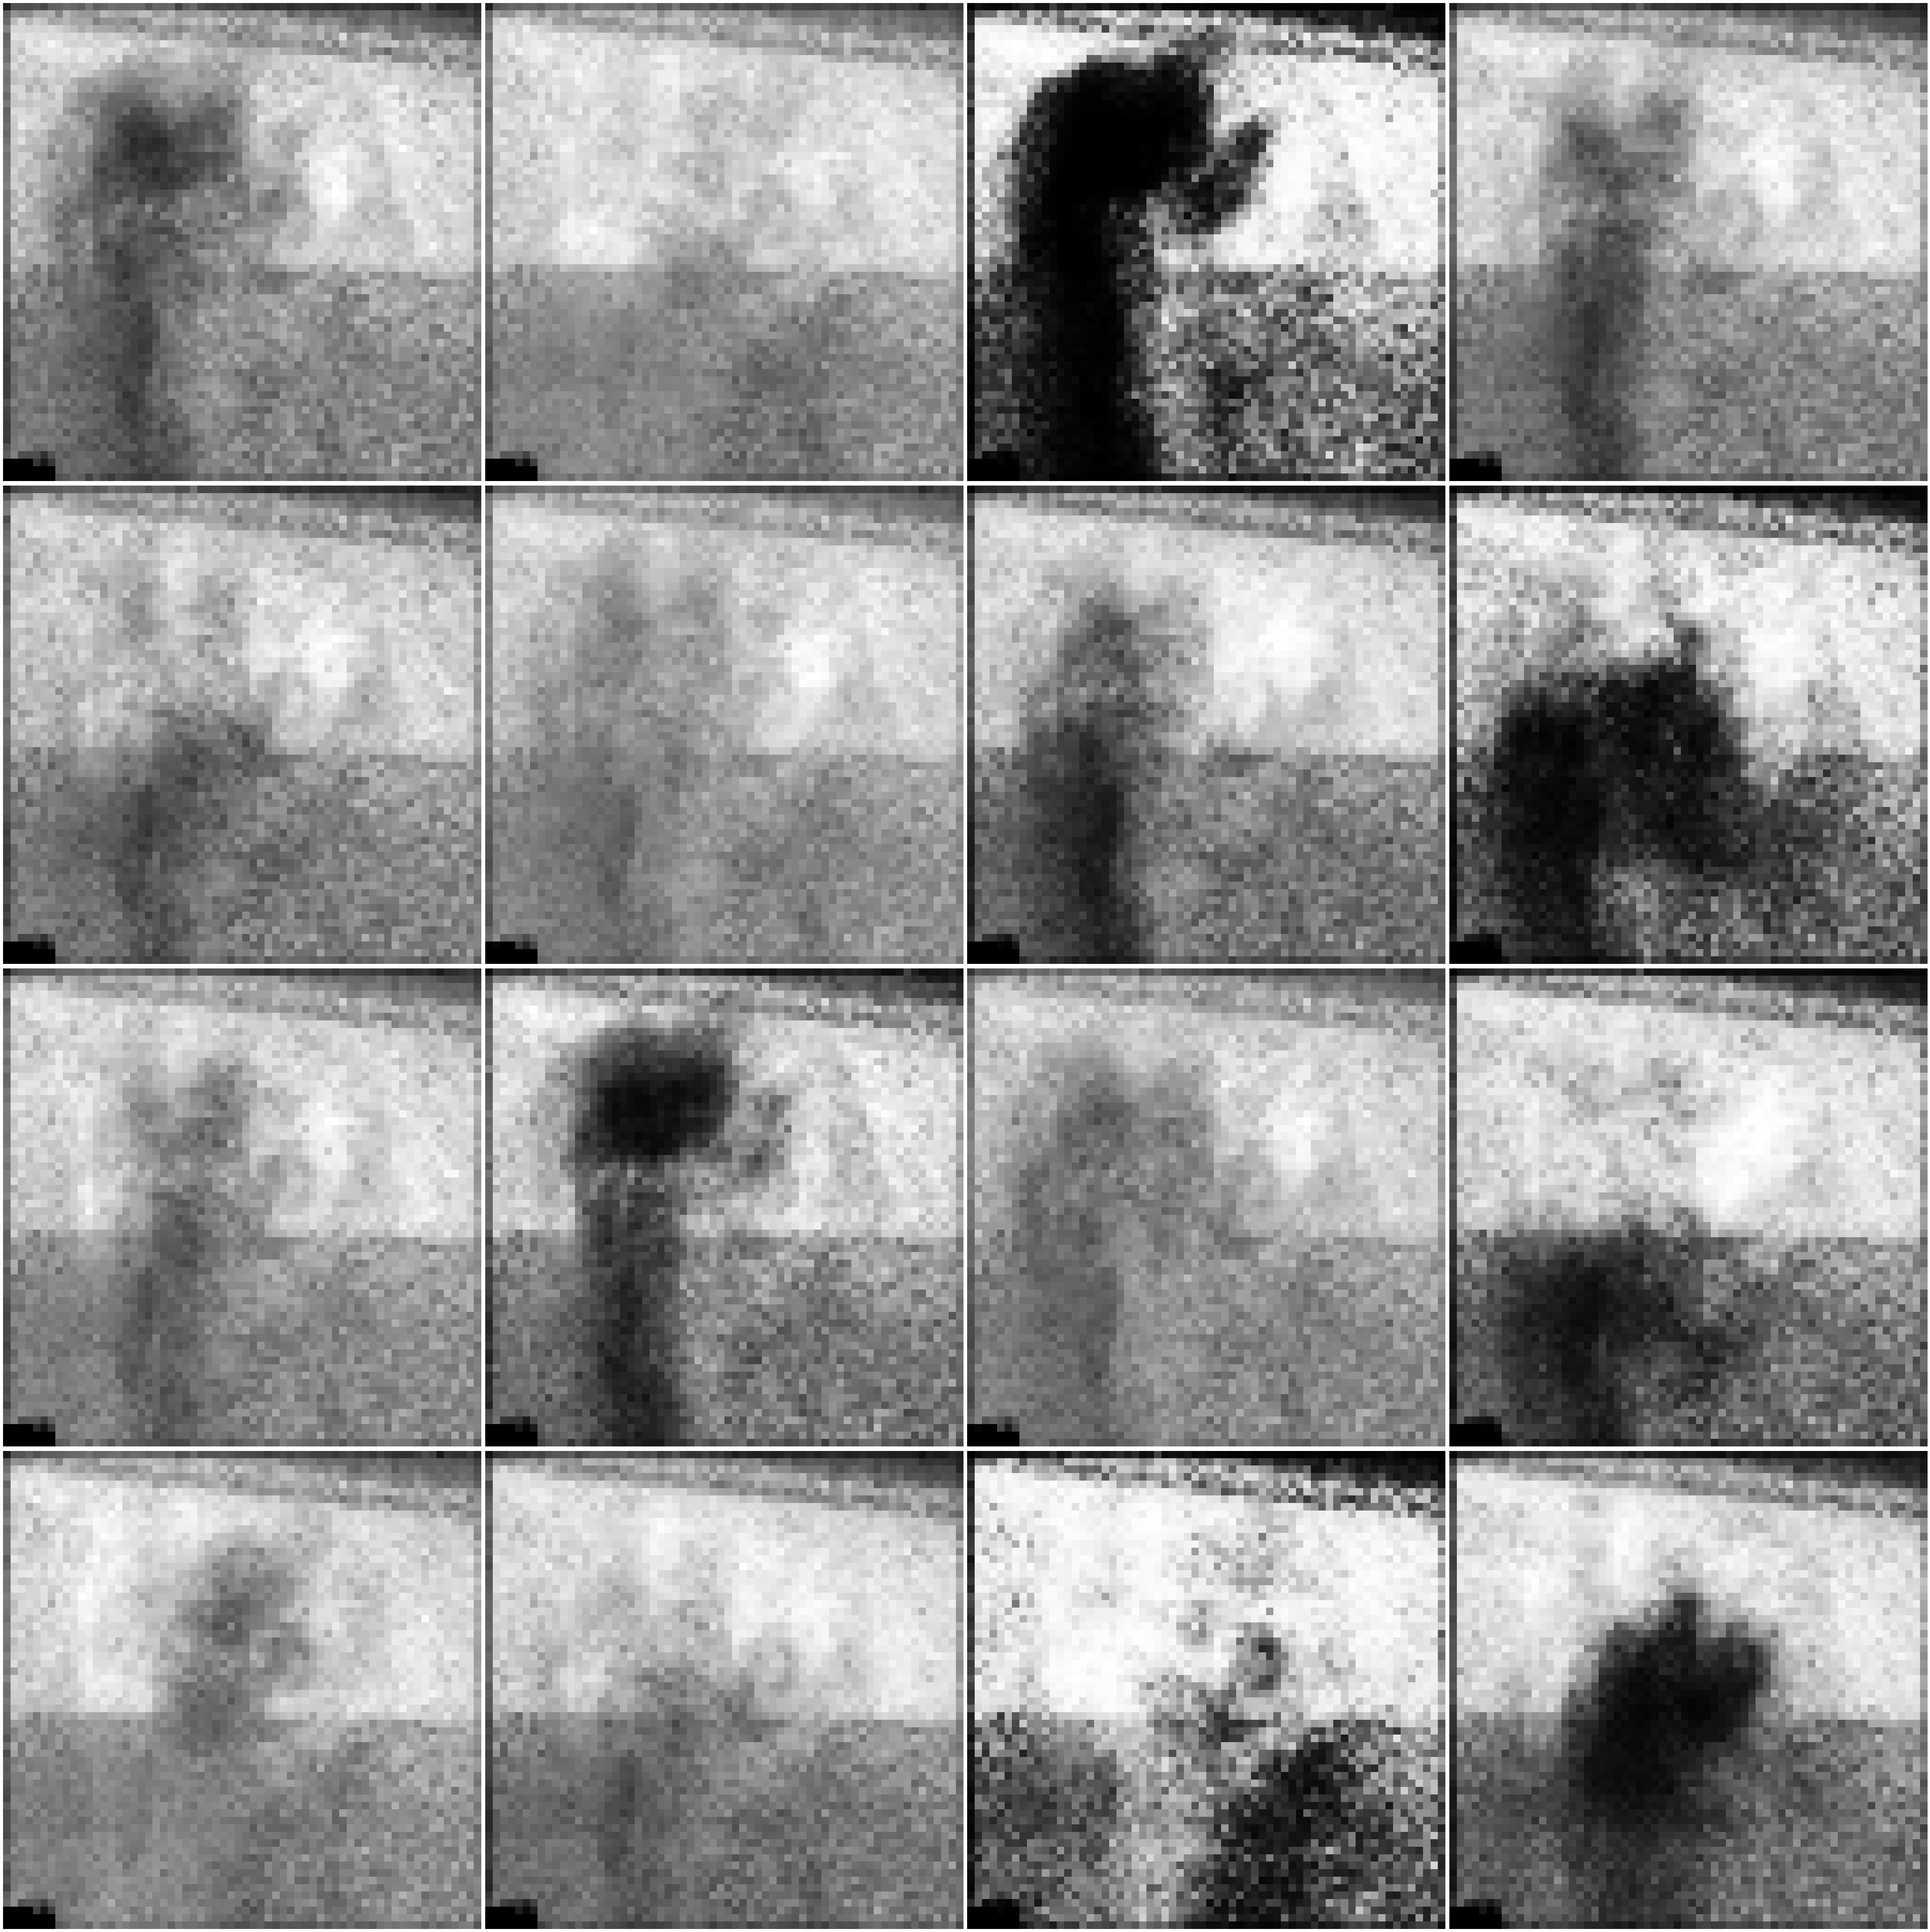

Starting training for letter: S
Completed Epoch 1/50, Epoch Duration: 7.33s, Total Loss D.: 0.0019, Total Loss G.: 8.6162
Completed Epoch 2/50, Epoch Duration: 6.90s, Total Loss D.: 0.0174, Total Loss G.: 6.9567
Completed Epoch 3/50, Epoch Duration: 6.79s, Total Loss D.: 0.0213, Total Loss G.: 8.5528
Completed Epoch 4/50, Epoch Duration: 6.81s, Total Loss D.: 0.0631, Total Loss G.: 5.5777
Completed Epoch 5/50, Epoch Duration: 6.79s, Total Loss D.: 0.0117, Total Loss G.: 5.6420
Completed Epoch 6/50, Epoch Duration: 6.89s, Total Loss D.: 0.0052, Total Loss G.: 5.5157
Completed Epoch 7/50, Epoch Duration: 7.08s, Total Loss D.: 0.0011, Total Loss G.: 8.4526
Completed Epoch 8/50, Epoch Duration: 6.93s, Total Loss D.: 0.0053, Total Loss G.: 6.8394
Completed Epoch 9/50, Epoch Duration: 6.80s, Total Loss D.: 0.0073, Total Loss G.: 7.1058
Completed Epoch 10/50, Epoch Duration: 6.94s, Total Loss D.: 0.0017, Total Loss G.: 7.6030
Completed Epoch 11/50, Epoch Duration: 6.79s, Total Loss D.: 0.0569

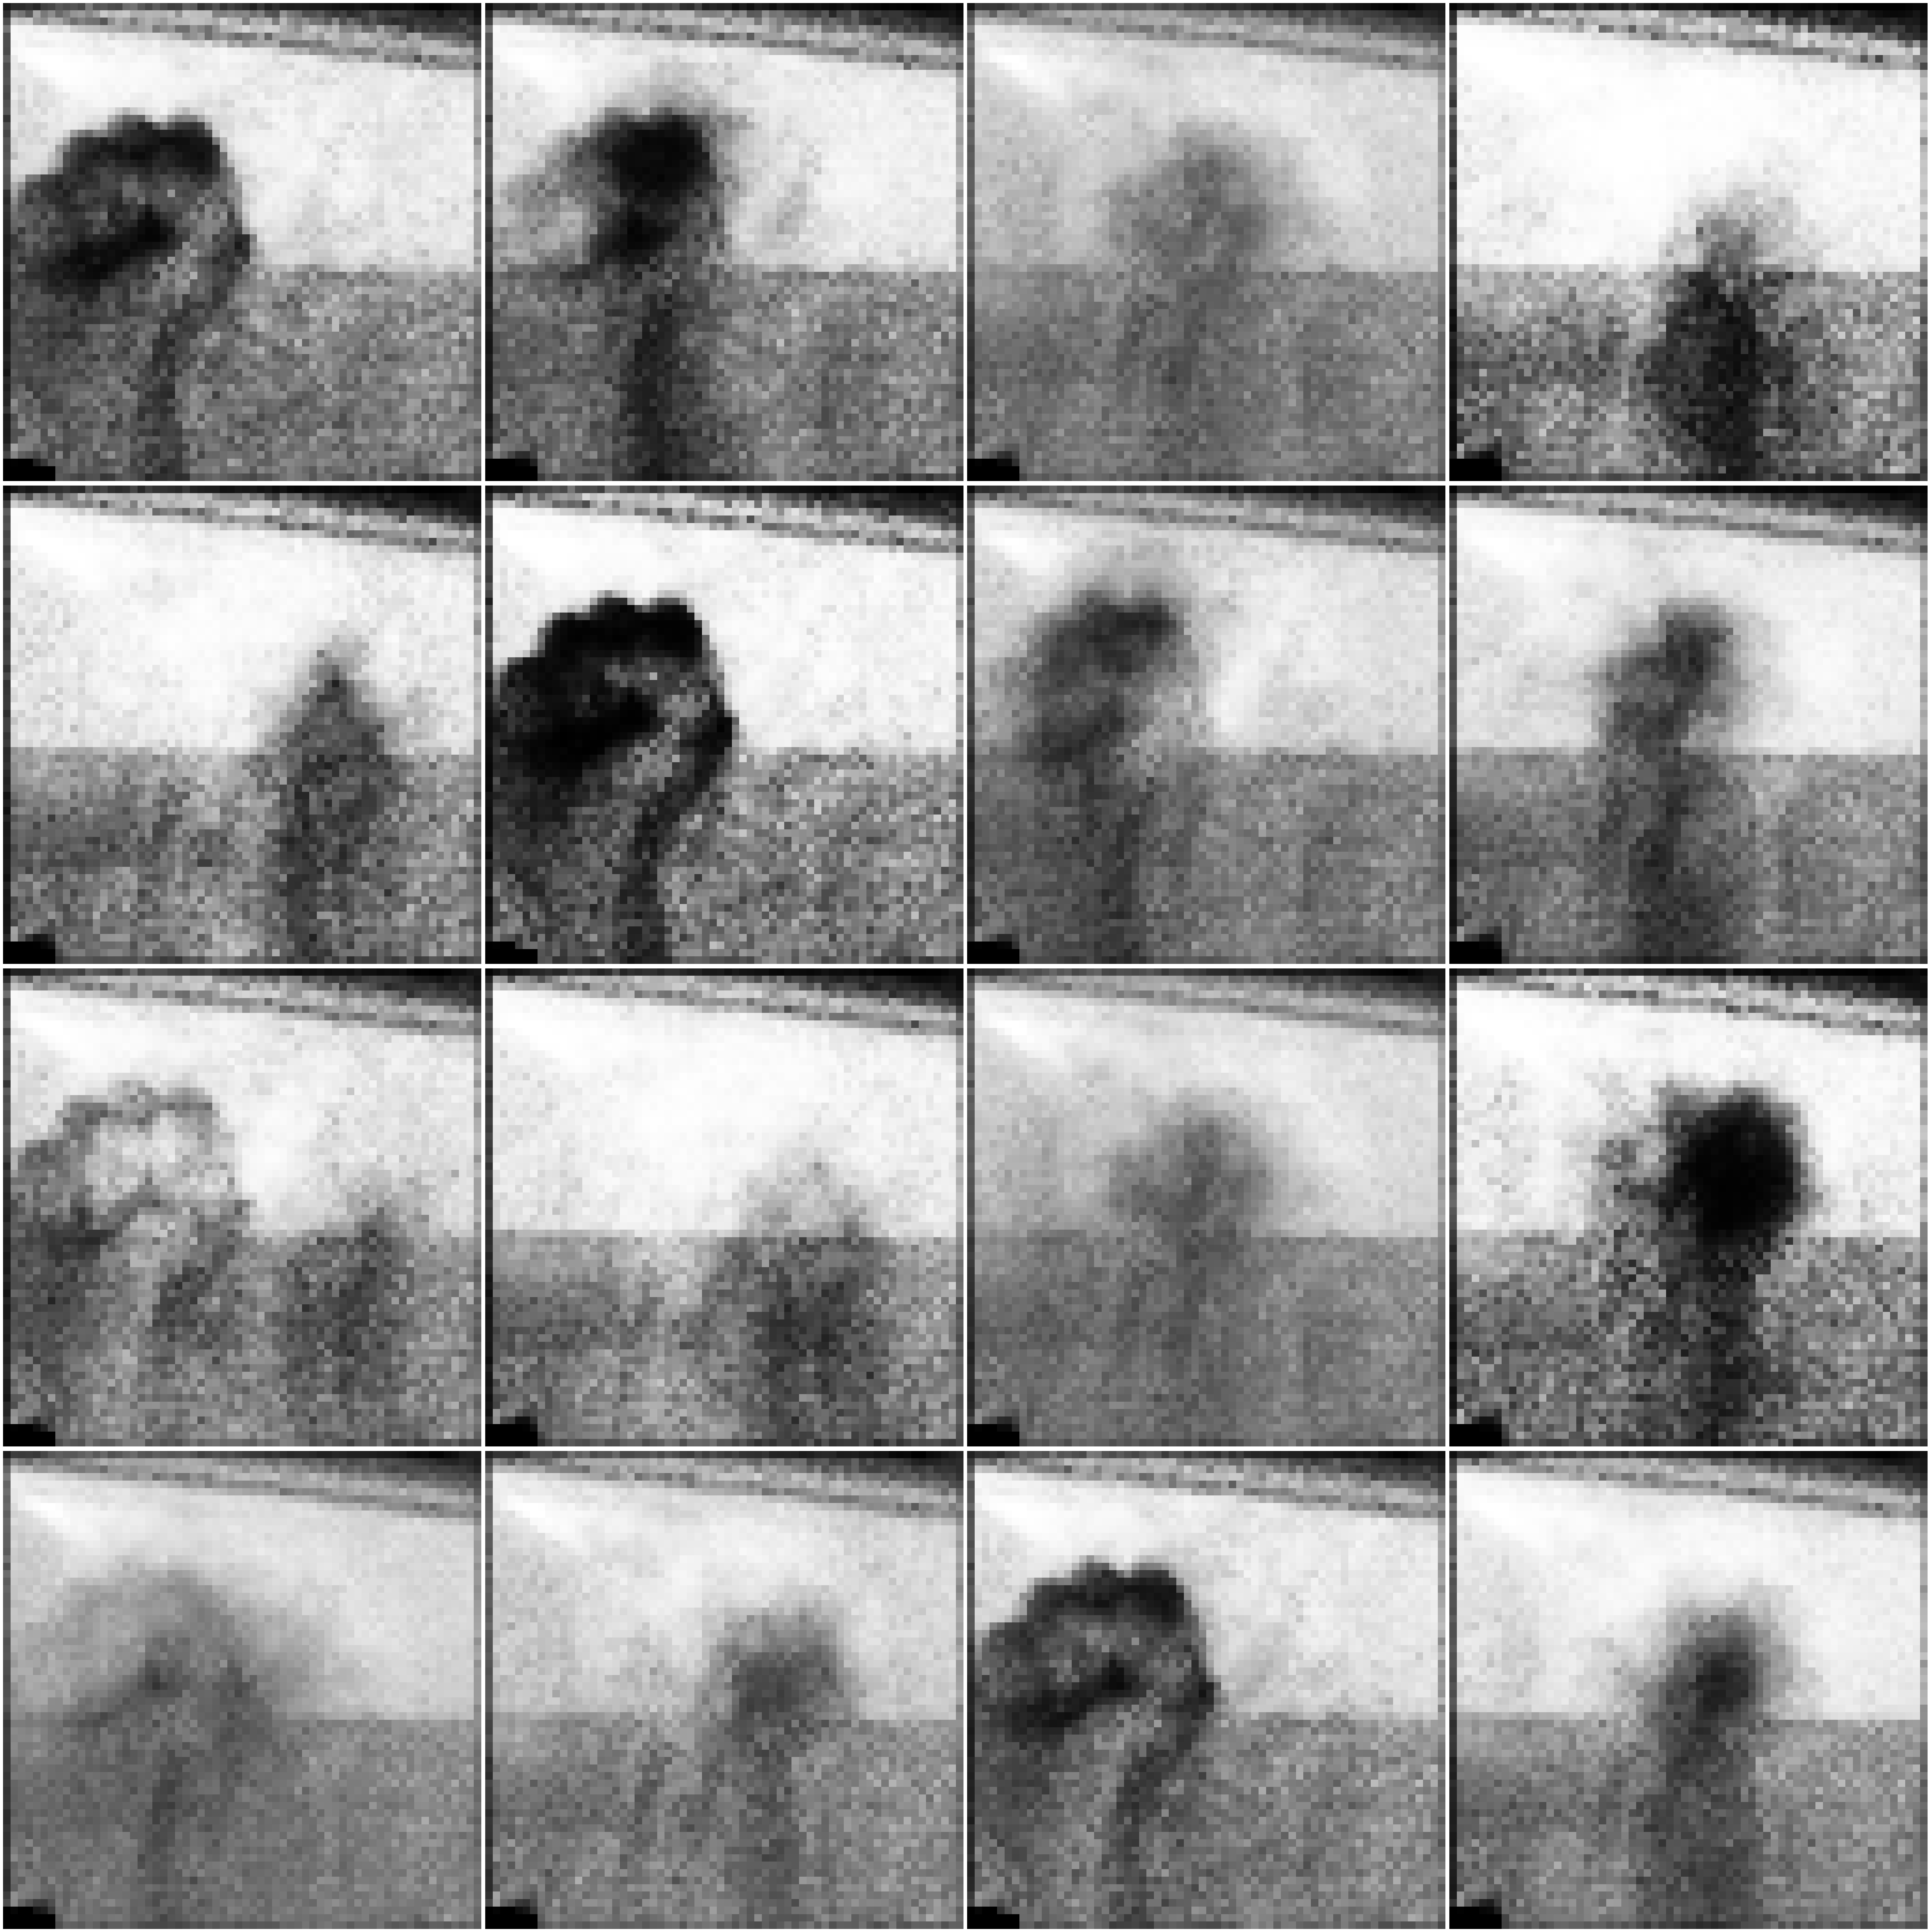

Starting training for letter: A
Completed Epoch 1/50, Epoch Duration: 7.36s, Total Loss D.: 0.0000, Total Loss G.: 14.0389
Completed Epoch 2/50, Epoch Duration: 7.43s, Total Loss D.: 0.0000, Total Loss G.: 17.8944
Completed Epoch 3/50, Epoch Duration: 10.50s, Total Loss D.: 0.0000, Total Loss G.: 14.3131
Completed Epoch 4/50, Epoch Duration: 6.70s, Total Loss D.: 0.0000, Total Loss G.: 14.4097
Completed Epoch 5/50, Epoch Duration: 6.68s, Total Loss D.: 0.0000, Total Loss G.: 15.4100
Completed Epoch 6/50, Epoch Duration: 6.62s, Total Loss D.: 0.0001, Total Loss G.: 9.4930
Completed Epoch 7/50, Epoch Duration: 6.67s, Total Loss D.: 0.0000, Total Loss G.: 14.0082
Completed Epoch 8/50, Epoch Duration: 6.60s, Total Loss D.: 0.0002, Total Loss G.: 10.6161
Completed Epoch 9/50, Epoch Duration: 6.61s, Total Loss D.: 0.1015, Total Loss G.: 20.8659
Completed Epoch 10/50, Epoch Duration: 6.52s, Total Loss D.: 0.0031, Total Loss G.: 15.5553
Completed Epoch 11/50, Epoch Duration: 6.72s, Total Loss 

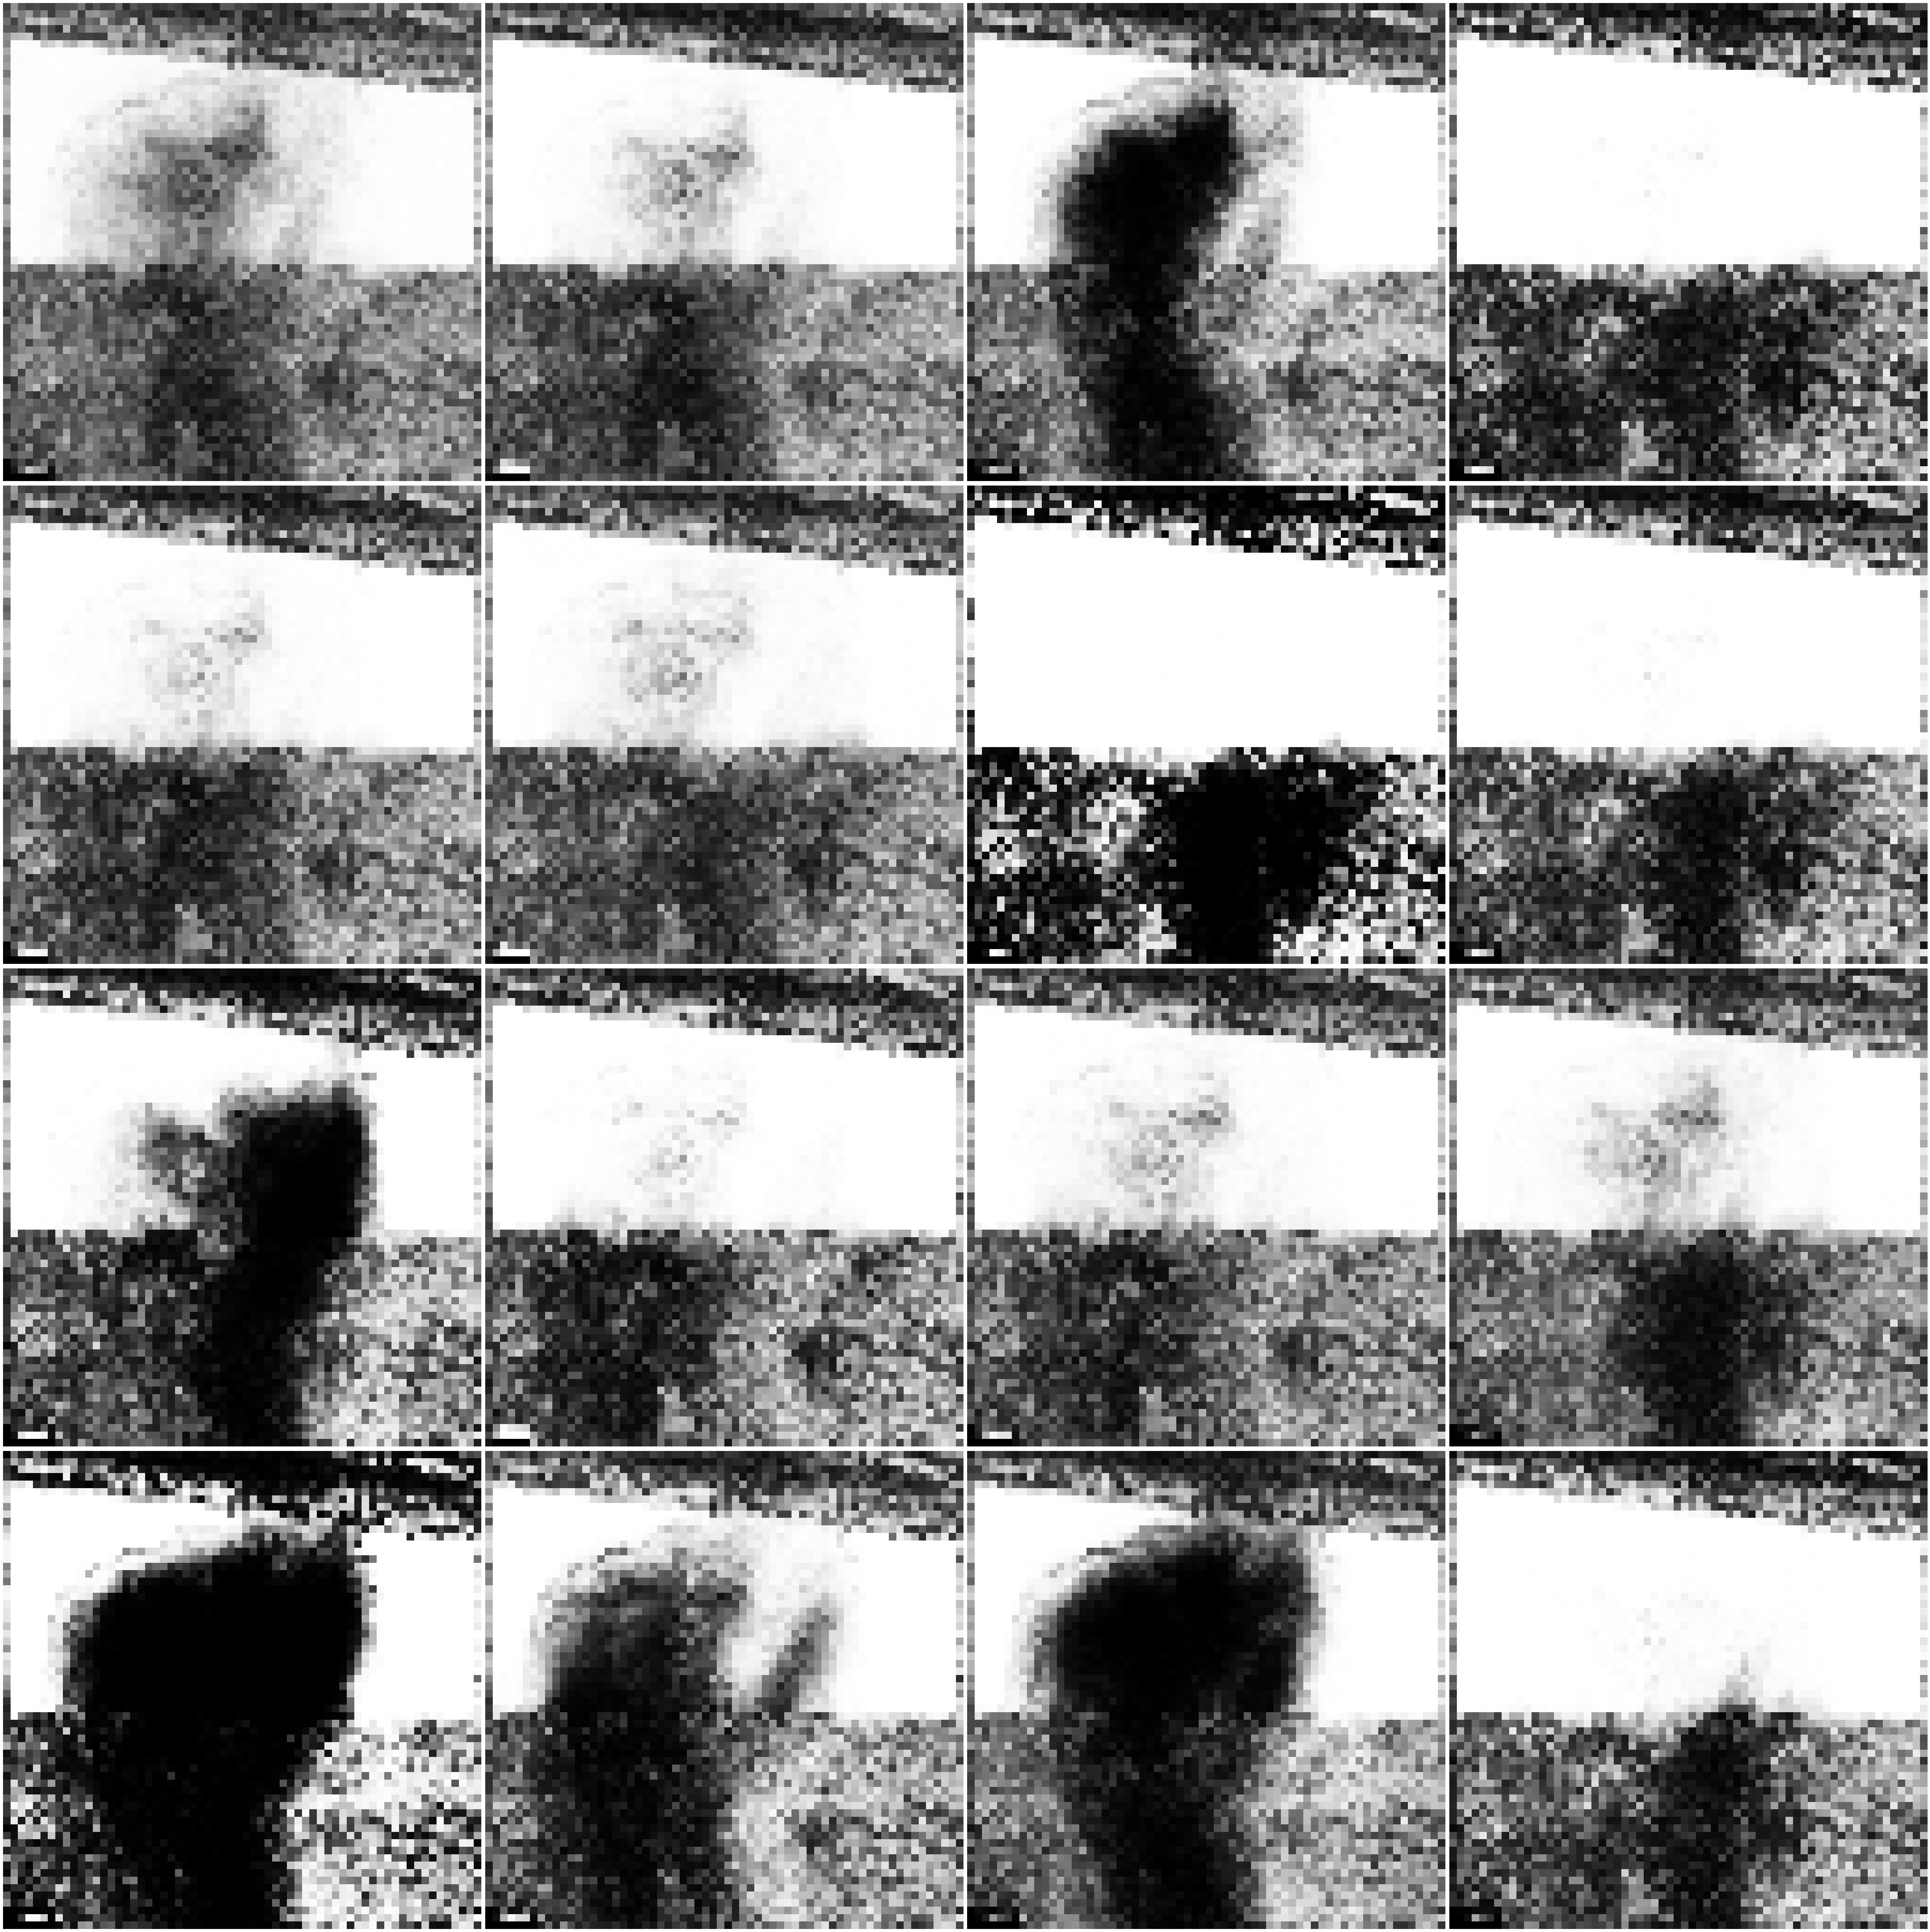

Starting training for letter: F
Completed Epoch 1/50, Epoch Duration: 7.22s, Total Loss D.: 0.0006, Total Loss G.: 8.7129
Completed Epoch 2/50, Epoch Duration: 6.67s, Total Loss D.: 0.0082, Total Loss G.: 6.8090
Completed Epoch 3/50, Epoch Duration: 6.65s, Total Loss D.: 0.0048, Total Loss G.: 7.9815
Completed Epoch 4/50, Epoch Duration: 6.61s, Total Loss D.: 0.0049, Total Loss G.: 7.9172
Completed Epoch 5/50, Epoch Duration: 6.61s, Total Loss D.: 0.0014, Total Loss G.: 8.3049
Completed Epoch 6/50, Epoch Duration: 6.60s, Total Loss D.: 0.0020, Total Loss G.: 7.2675
Completed Epoch 7/50, Epoch Duration: 6.61s, Total Loss D.: 0.0005, Total Loss G.: 8.1826
Completed Epoch 8/50, Epoch Duration: 6.61s, Total Loss D.: 0.0022, Total Loss G.: 8.1837
Completed Epoch 9/50, Epoch Duration: 6.58s, Total Loss D.: 0.0104, Total Loss G.: 7.2729
Completed Epoch 10/50, Epoch Duration: 6.63s, Total Loss D.: 0.0386, Total Loss G.: 8.1947
Completed Epoch 11/50, Epoch Duration: 6.68s, Total Loss D.: 0.0014

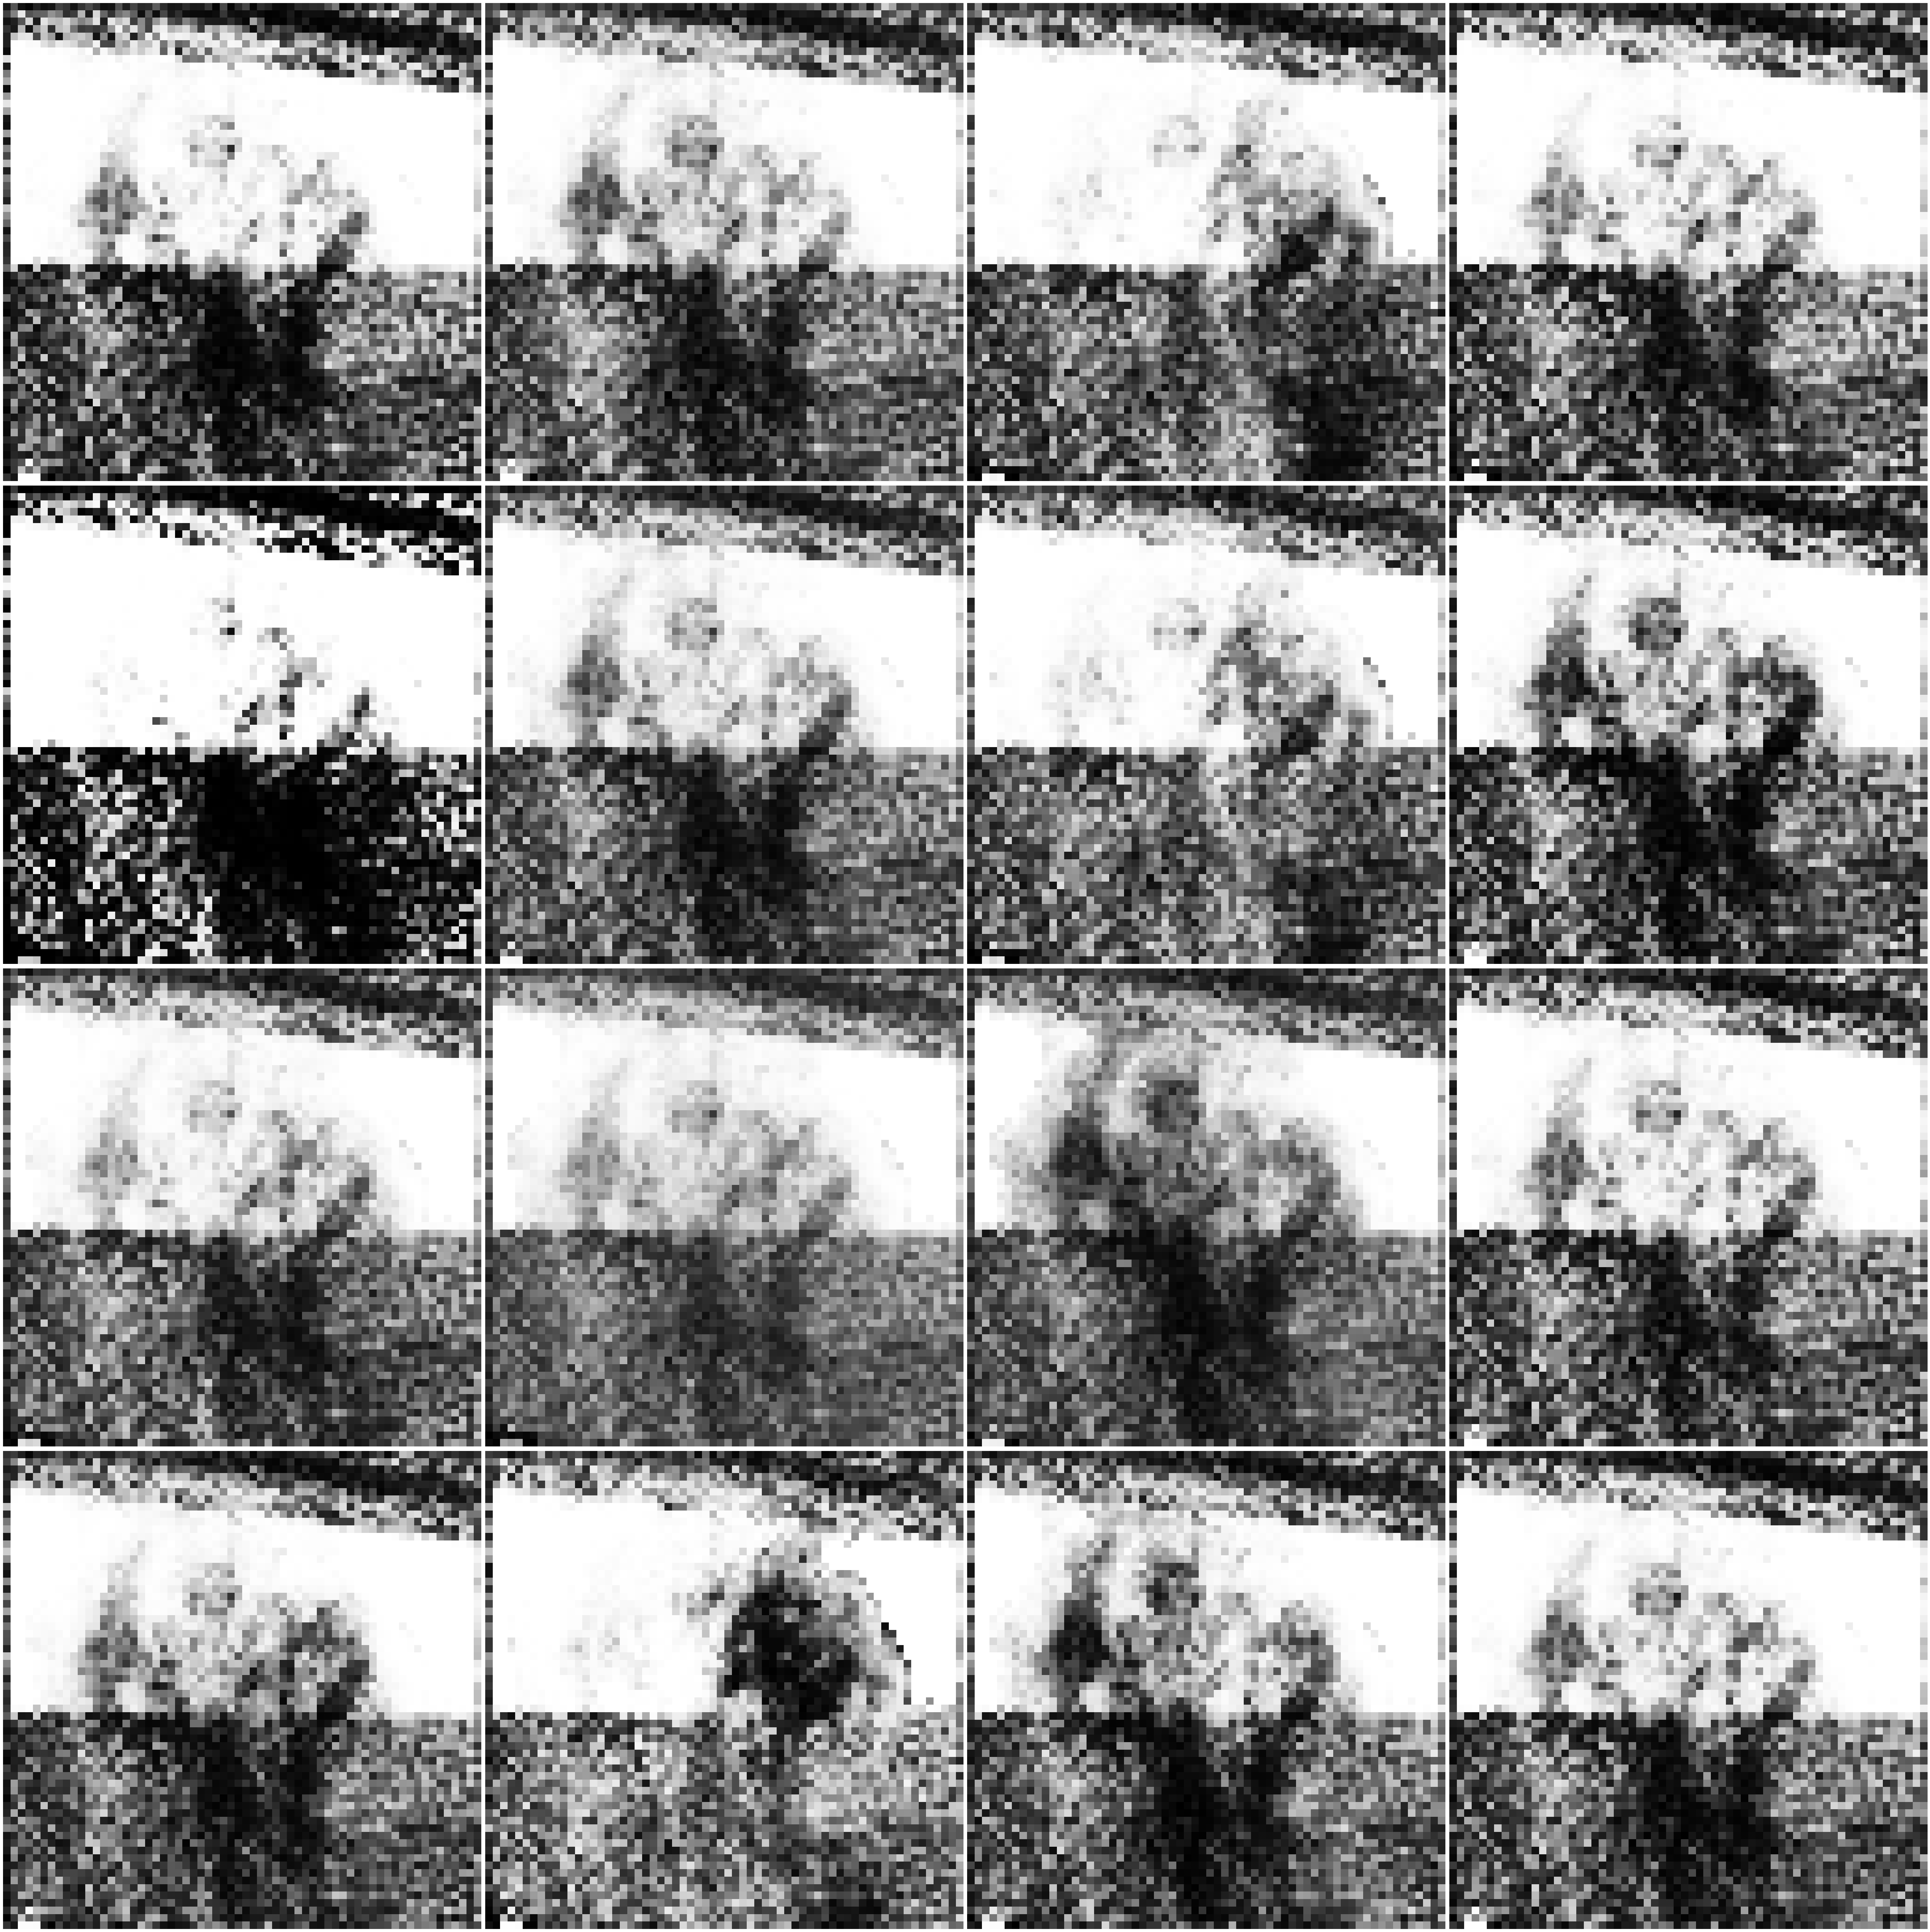

Starting training for letter: O
Completed Epoch 1/50, Epoch Duration: 7.24s, Total Loss D.: 0.2872, Total Loss G.: 11.4733
Completed Epoch 2/50, Epoch Duration: 6.53s, Total Loss D.: 0.0103, Total Loss G.: 10.1093
Completed Epoch 3/50, Epoch Duration: 6.54s, Total Loss D.: 0.0277, Total Loss G.: 7.7414
Completed Epoch 4/50, Epoch Duration: 6.57s, Total Loss D.: 0.0364, Total Loss G.: 4.7755
Completed Epoch 5/50, Epoch Duration: 6.59s, Total Loss D.: 0.0657, Total Loss G.: 5.5241
Completed Epoch 6/50, Epoch Duration: 6.54s, Total Loss D.: 0.0271, Total Loss G.: 6.8957
Completed Epoch 7/50, Epoch Duration: 6.55s, Total Loss D.: 0.1057, Total Loss G.: 7.0851
Completed Epoch 8/50, Epoch Duration: 6.70s, Total Loss D.: 0.0128, Total Loss G.: 7.5146
Completed Epoch 9/50, Epoch Duration: 6.80s, Total Loss D.: 0.0163, Total Loss G.: 7.1543
Completed Epoch 10/50, Epoch Duration: 7.05s, Total Loss D.: 0.0184, Total Loss G.: 8.7372
Completed Epoch 11/50, Epoch Duration: 6.87s, Total Loss D.: 0.02

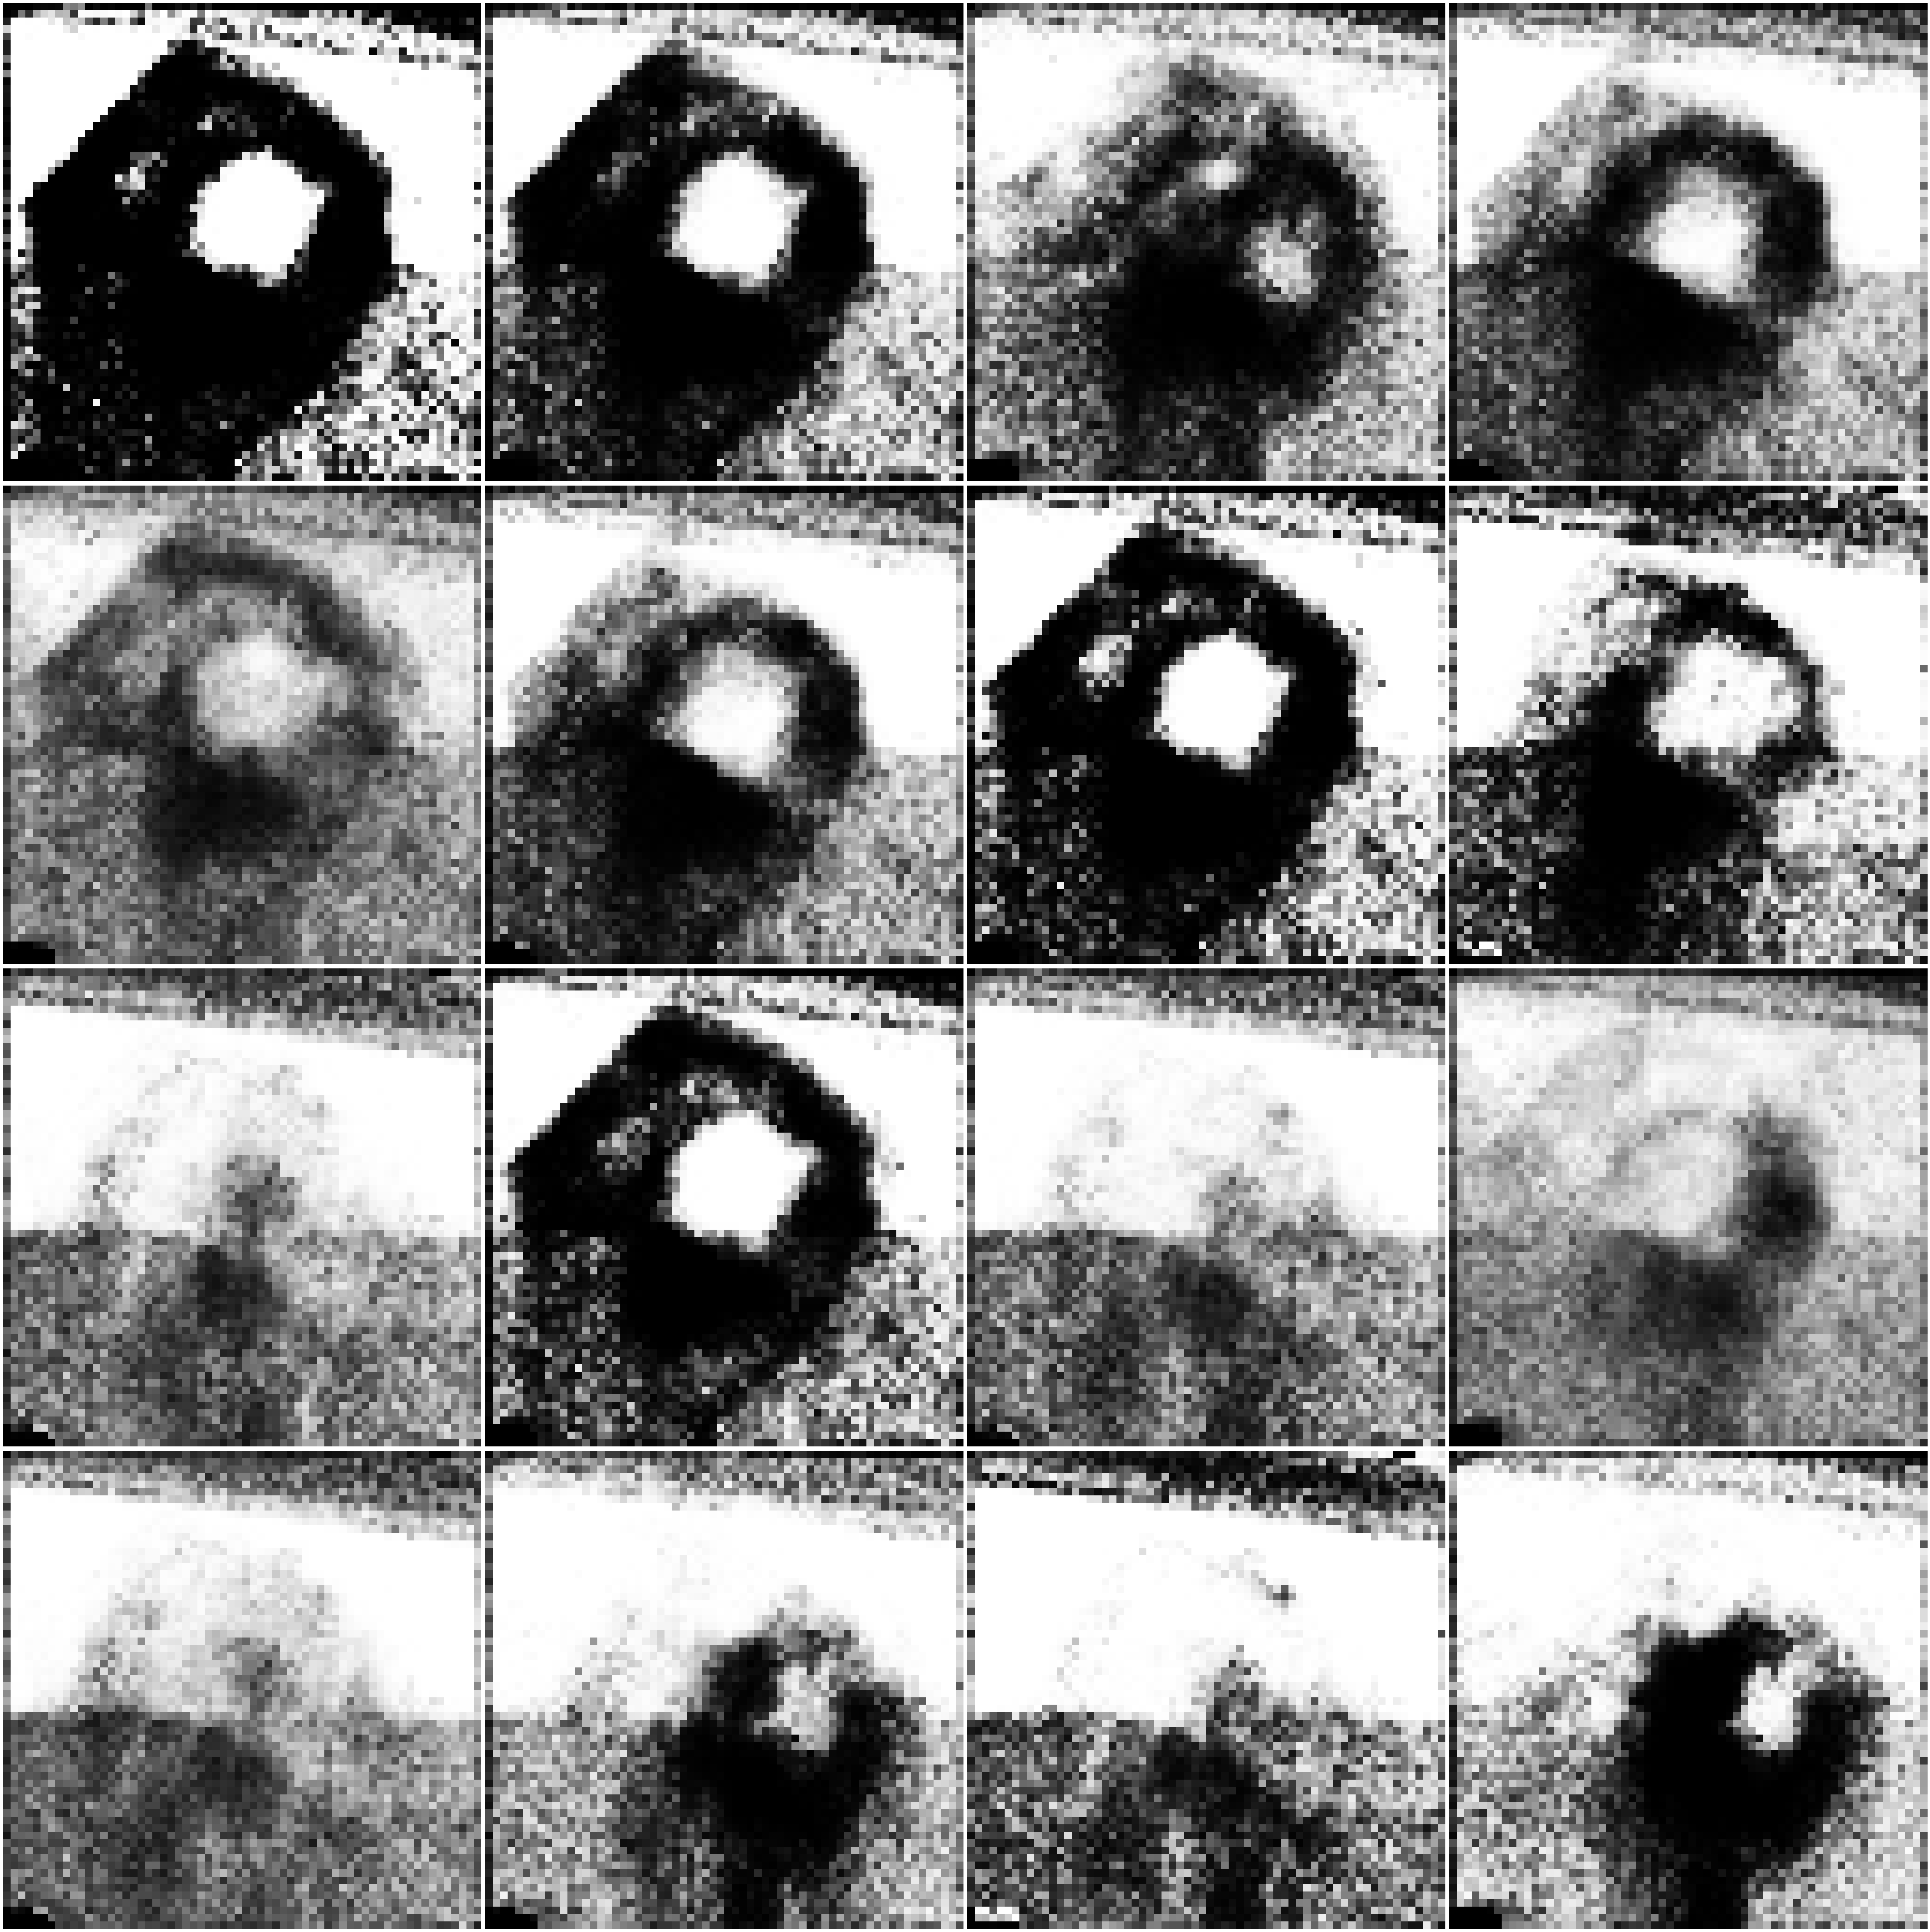

Starting training for letter: H
Completed Epoch 1/50, Epoch Duration: 7.34s, Total Loss D.: 0.0064, Total Loss G.: 9.1235
Completed Epoch 2/50, Epoch Duration: 6.95s, Total Loss D.: 0.0019, Total Loss G.: 8.6718
Completed Epoch 3/50, Epoch Duration: 6.84s, Total Loss D.: 0.0040, Total Loss G.: 7.7307
Completed Epoch 4/50, Epoch Duration: 6.90s, Total Loss D.: 0.0010, Total Loss G.: 9.3177
Completed Epoch 5/50, Epoch Duration: 6.85s, Total Loss D.: 0.0034, Total Loss G.: 7.2373
Completed Epoch 6/50, Epoch Duration: 6.84s, Total Loss D.: 0.0005, Total Loss G.: 8.8870
Completed Epoch 7/50, Epoch Duration: 6.89s, Total Loss D.: 0.0016, Total Loss G.: 8.6118
Completed Epoch 8/50, Epoch Duration: 6.86s, Total Loss D.: 0.0038, Total Loss G.: 9.2041
Completed Epoch 9/50, Epoch Duration: 6.87s, Total Loss D.: 0.0021, Total Loss G.: 6.1555
Completed Epoch 10/50, Epoch Duration: 6.85s, Total Loss D.: 0.0017, Total Loss G.: 9.4720
Completed Epoch 11/50, Epoch Duration: 6.89s, Total Loss D.: 0.0006

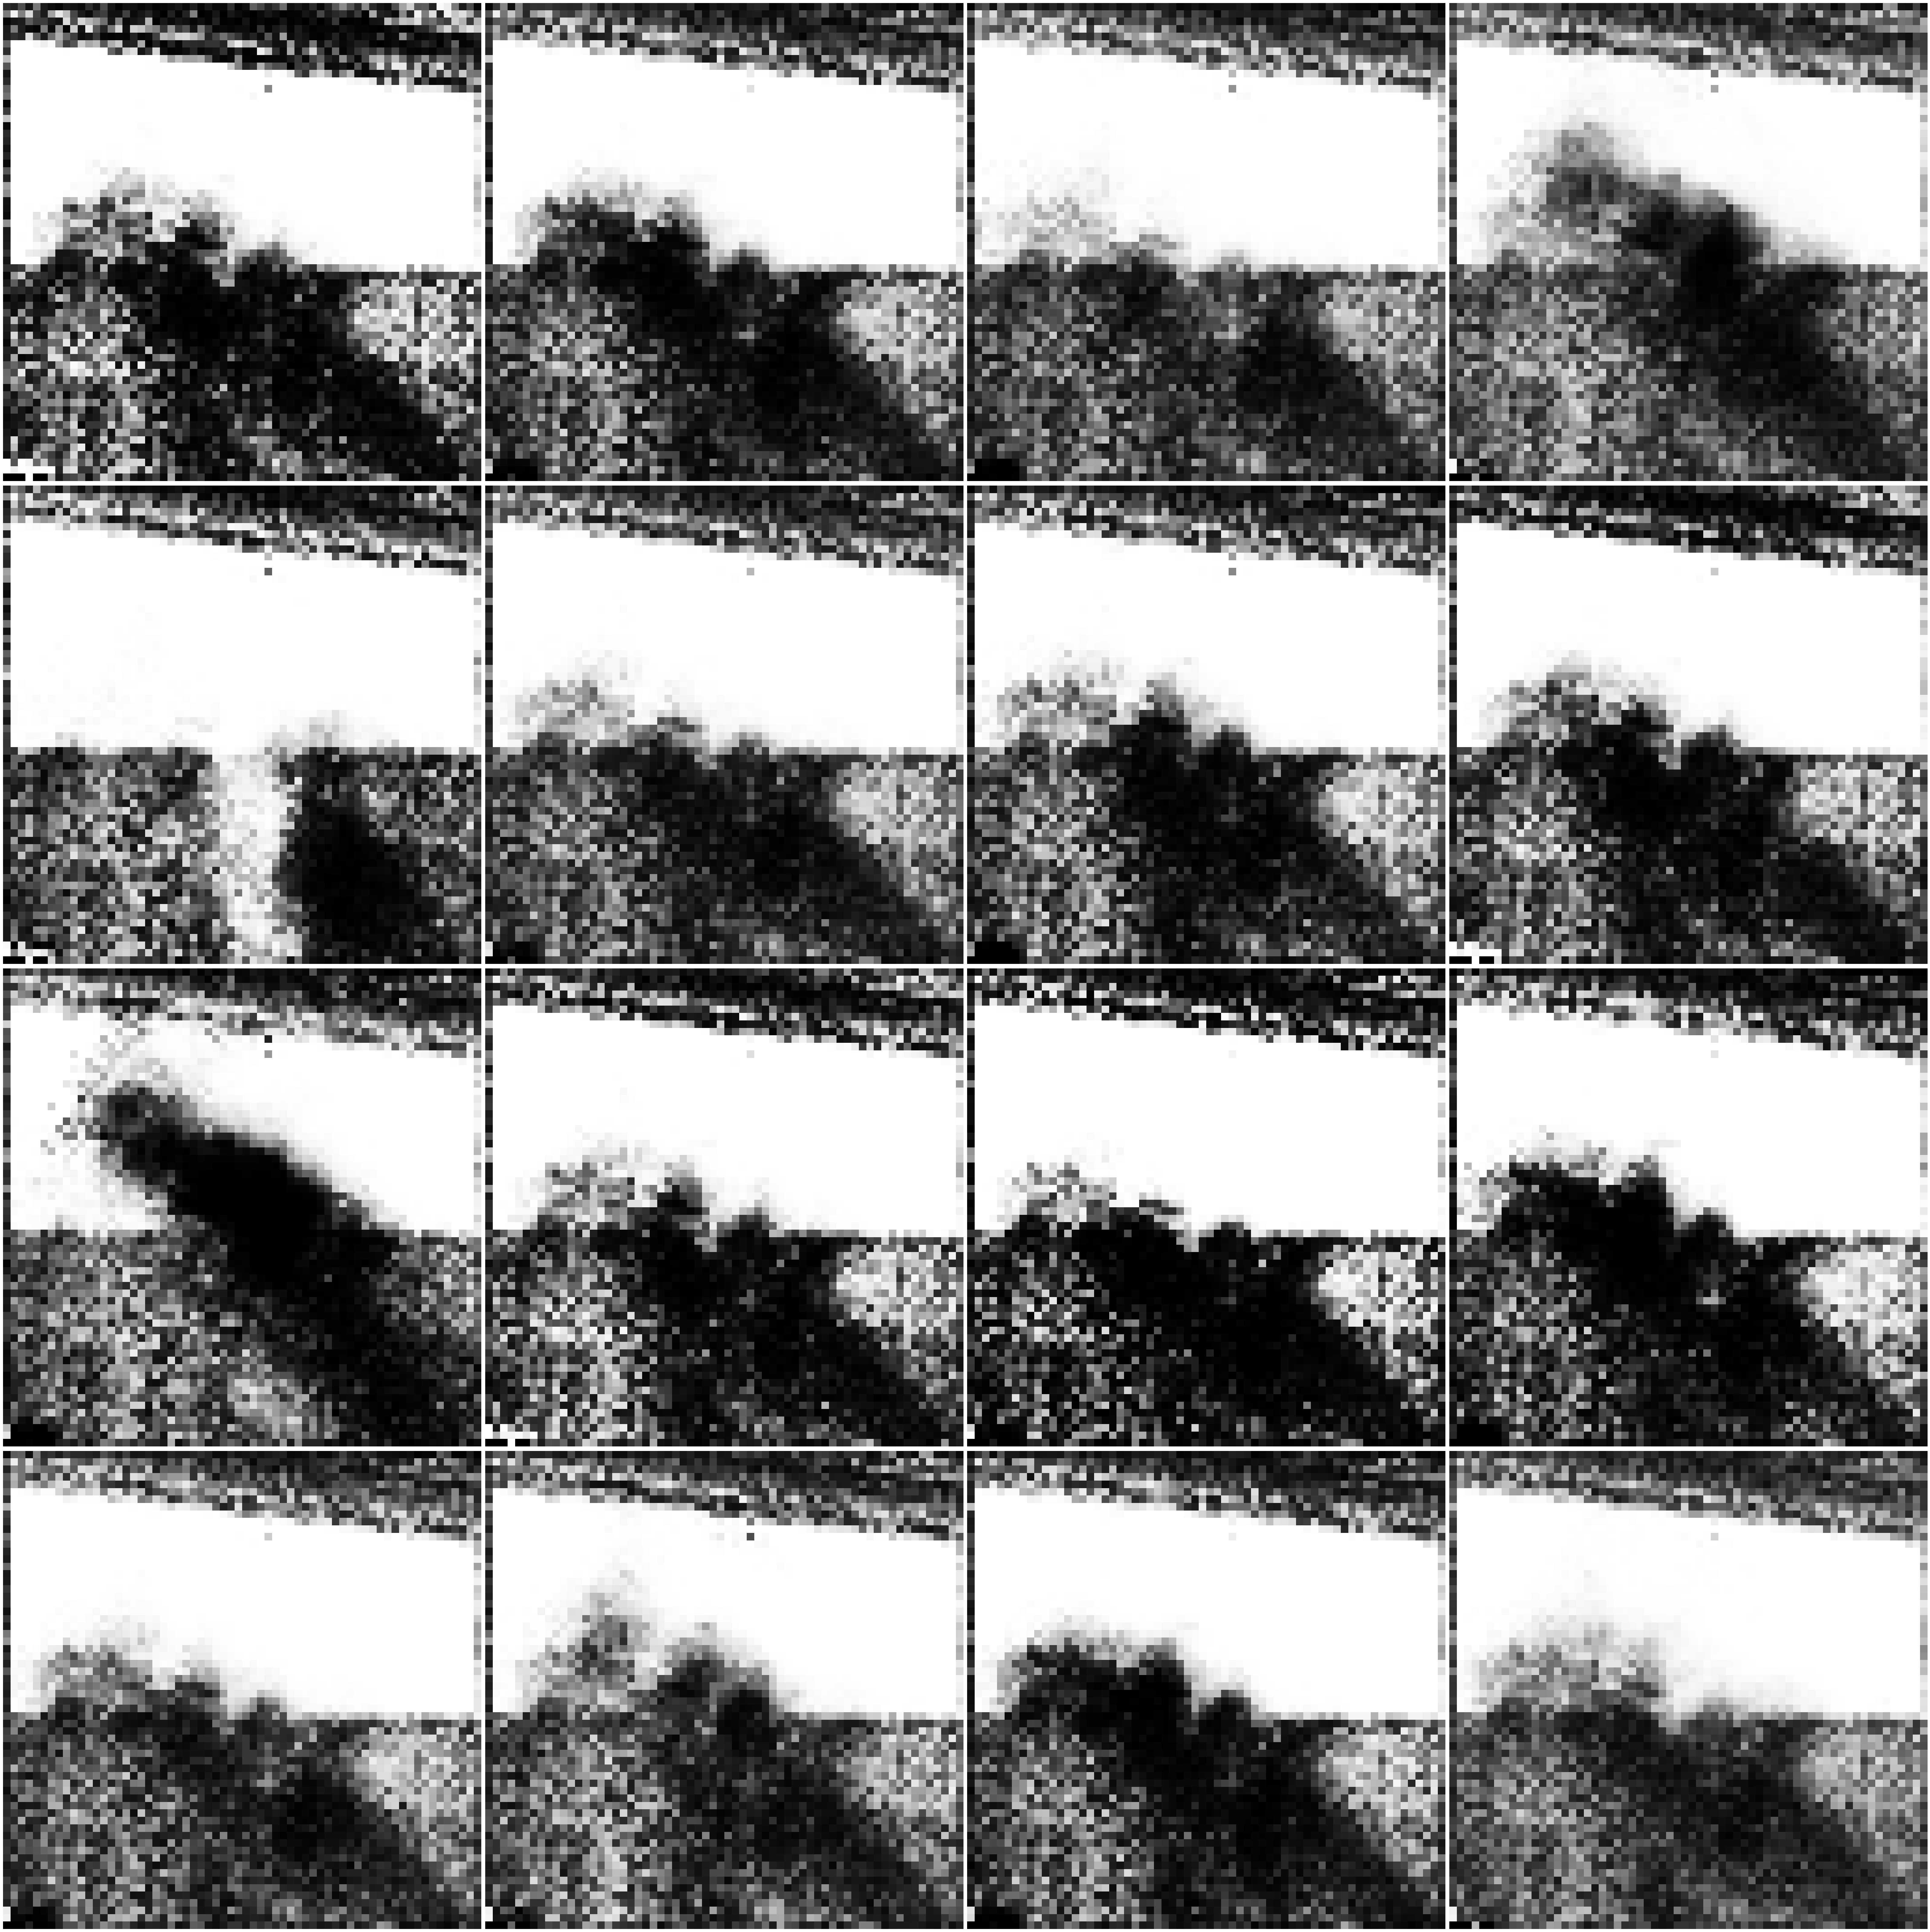

Starting training for letter: M
Completed Epoch 1/50, Epoch Duration: 7.51s, Total Loss D.: 0.0005, Total Loss G.: 11.7373
Completed Epoch 2/50, Epoch Duration: 7.48s, Total Loss D.: 0.0053, Total Loss G.: 5.7402
Completed Epoch 3/50, Epoch Duration: 7.34s, Total Loss D.: 0.0016, Total Loss G.: 10.8263
Completed Epoch 4/50, Epoch Duration: 7.19s, Total Loss D.: 0.0016, Total Loss G.: 10.5382
Completed Epoch 5/50, Epoch Duration: 6.64s, Total Loss D.: 0.0072, Total Loss G.: 9.2728
Completed Epoch 6/50, Epoch Duration: 6.90s, Total Loss D.: 0.0002, Total Loss G.: 8.4836
Completed Epoch 7/50, Epoch Duration: 6.82s, Total Loss D.: 0.0007, Total Loss G.: 8.0465
Completed Epoch 8/50, Epoch Duration: 6.93s, Total Loss D.: 0.0001, Total Loss G.: 10.0686
Completed Epoch 9/50, Epoch Duration: 7.16s, Total Loss D.: 0.0003, Total Loss G.: 9.0144
Completed Epoch 10/50, Epoch Duration: 7.08s, Total Loss D.: 0.0005, Total Loss G.: 6.4101
Completed Epoch 11/50, Epoch Duration: 6.73s, Total Loss D.: 0.

In [ ]:
for letter, dataloader in gan_dataloaders.items():
    print(f"Starting training for letter: {letter}")
    for epoch in range(num_epochs):
        start_time_epoch = time.time()
        for n, (real_samples, _) in enumerate(dataloader):
                start_time_batch = time.time()

                batch_size_current = real_samples.size(0)
                real_samples = real_samples.to(device=device)
                real_samples_labels = torch.ones((batch_size_current, 1), device=device)

                latent_space_samples = torch.randn((batch_size_current, 100), device=device)
                generated_samples = generator(latent_space_samples)
                generated_samples_labels = torch.zeros((batch_size_current, 1), device=device)

                all_samples = torch.cat((real_samples, generated_samples), dim=0)
                all_samples_labels = torch.cat((real_samples_labels, generated_samples_labels), dim=0)

                discriminator.zero_grad()

                output_discriminator = discriminator(all_samples)
                loss_discriminator = loss_function(output_discriminator, all_samples_labels)
                loss_discriminator.backward()
                optimizer_discriminator.step()


                generator.zero_grad()
                latent_space_samples = torch.randn((batch_size_current, 100), device=device)
                generated_samples = generator(latent_space_samples)
                output_discriminator_generated = discriminator(generated_samples)
                loss_generator = loss_function(output_discriminator_generated, real_samples_labels) 
                loss_generator.backward()
                optimizer_generator.step()

                end_time_batch = time.time()
                batch_duration = end_time_batch - start_time_batch


        end_time_epoch = time.time()
        epoch_duration = end_time_epoch - start_time_epoch 
        print(f"Completed Epoch {epoch+1}/{num_epochs}, "
            f"Epoch Duration: {epoch_duration:.2f}s, "
            f"Total Loss D.: {loss_discriminator.item():.4f}, " 
            f"Total Loss G.: {loss_generator.item():.4f}")
        
    latent_space_samples = torch.randn(32, 100).to(device=device)
    generated_samples = generator(latent_space_samples) 
    generated_samples = generated_samples.cpu().detach()
    show_asl(16, 4, 4, generated_samples)